In [1]:
from scipy.sparse import triu
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from collections import Counter
from itertools import combinations
import itertools
from datetime import datetime
import networkx as nx
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis.lda_model
import re

# Ecuaciones de busqueda



Scopus

(TITLE-ABS-KEY("computer vision" OR "image analysis" OR "image processing" 
OR "deep learning" OR "machine learning" 
OR "convolutional neural network" OR CNN 
OR "artificial intelligence"))
AND
(TITLE-ABS-KEY("nutritional quality" OR "fruit quality" 
OR "macronutrients" OR "micronutrients" 
OR "vitamin content" OR vitamins 
OR "mineral content" OR minerals 
OR carbohydrates OR proteins OR lipids OR sugars OR starch 
OR "nutrient composition"))
AND
(TITLE-ABS-KEY("crop yield" OR "yield prediction" OR "agricultural productivity" 
OR "leaf disease" OR "plant disease" OR "foliar disease" OR "plant pathology"))

# limpieza de datos 

In [4]:
df = pd.read_csv("referencias_unificado.csv",delimiter='|')

In [ ]:
print("Dimensiones del dataset:", df.shape)
print("\nInformación general y tipos de datos:")
df.info()

Dimensiones del dataset: (1367, 24)

Información general y tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1367 entries, 0 to 1366
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fuente             1367 non-null   object 
 1   authors            1241 non-null   object 
 2   author_full_names  808 non-null    object 
 3   Author_ID          808 non-null    object 
 4   title              1367 non-null   object 
 5   year               1367 non-null   int64  
 6   source_title       1179 non-null   object 
 7   volume             825 non-null    object 
 8   issue              463 non-null    object 
 9   art                315 non-null    object 
 10  page_start         756 non-null    object 
 11  page_end           752 non-null    object 
 12  page_count         704 non-null    object 
 13  cited_by           895 non-null    float64
 14  DOI                1101 non-null   object 
 1

In [9]:
print(df.isnull().sum())

fuente                  0
authors               126
author_full_names     559
Author_ID             559
title                   0
year                    0
source_title          188
volume                542
issue                 904
art                  1052
page_start            611
page_end              615
page_count            663
cited_by              472
DOI                   266
link                  382
abstract               64
author_Keywords       571
index_keywords        656
document_type          90
publication_stage     472
open_access          1144
source                472
EID                   472
dtype: int64


In [10]:
# Eliminar filas donde el título o el abstract son nulos
df.dropna(subset=['title', 'abstract'], inplace=True)

In [11]:
# Rellenar valores nulos en columnas numéricas
numeric_cols = ['cited_by', 'page_count', 'volume', 'issue']
for col in numeric_cols:
    if col in df.columns:
        df[col].fillna(0, inplace=True)

# Rellenar valores nulos en columnas de texto
text_cols = ['authors', 'author_Keywords', 'index_keywords']
for col in text_cols:
    if col in df.columns:
        df[col].fillna('Desconocido', inplace=True)

/tmp/ipykernel_3148928/2588457276.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)
/tmp/ipykernel_3148928/2588457276.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

In [12]:
# Convertir columnas a tipo numérico, los errores se convertirán en NaN (Not a Number)
numeric_cols_to_convert = ['year', 'cited_by', 'page_count']
for col in numeric_cols_to_convert:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Después de la conversión, podrías tener nuevos NaN que necesitarás rellenar (por ejemplo, con 0 o la mediana)
df.fillna(0, inplace=True)

# Convertir a enteros si es apropiado
integer_cols = ['year', 'cited_by', 'page_count']
for col in integer_cols:
    if col in df.columns:
        df[col] = df[col].astype(int)

print("\nTipos de datos después de la corrección:")
df.info()



Tipos de datos después de la corrección:
<class 'pandas.core.frame.DataFrame'>
Index: 1303 entries, 0 to 1366
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   fuente             1303 non-null   object
 1   authors            1303 non-null   object
 2   author_full_names  1303 non-null   object
 3   Author_ID          1303 non-null   object
 4   title              1303 non-null   object
 5   year               1303 non-null   int64 
 6   source_title       1303 non-null   object
 7   volume             1303 non-null   object
 8   issue              1303 non-null   object
 9   art                1303 non-null   object
 10  page_start         1303 non-null   object
 11  page_end           1303 non-null   object
 12  page_count         1303 non-null   int64 
 13  cited_by           1303 non-null   int64 
 14  DOI                1303 non-null   object
 15  link               1303 non-null   object
 16  abstr

In [13]:
# Contar duplicados antes de eliminar
print(f"Número de filas duplicadas basadas en DOI: {df.duplicated(subset=['DOI']).sum()}")
print(f"Número de filas duplicadas basadas en EID: {df.duplicated(subset=['EID']).sum()}")

# Eliminar duplicados, manteniendo la primera aparición
# Es buena idea priorizar el DOI ya que es un estándar más universal
df.dropna(subset=['DOI'], inplace=True) # Primero nos aseguramos que no haya nulos en DOI
df.drop_duplicates(subset=['DOI'], keep='first', inplace=True)

print(f"\nDimensiones del dataset después de eliminar duplicados: {df.shape}")


Número de filas duplicadas basadas en DOI: 205
Número de filas duplicadas basadas en EID: 407

Dimensiones del dataset después de eliminar duplicados: (1098, 24)


In [14]:
df.head(3)

,fuente,authors,author_full_names,Author_ID,title,year,source_title,volume,issue,art,...,DOI,link,abstract,author_Keywords,index_keywords,document_type,publication_stage,open_access,source,EID
0,scopus,Desconocido,0,0,Future of Information and Communication Confer...,2025,Lecture Notes in Networks and Systems,1283 LNNS,0,0,...,0,https://www.scopus.com/inward/record.uri?eid=2...,The proceedings contain 138 papers. The specia...,Desconocido,Desconocido,Conference review,Final,0,Scopus,2-s2.0-105000643403
1,scopus,Adline Freeda R.; Sudha K.,"Adline Freeda, R. (57191618601); Sudha, K. (59...",57191618601; 59978506500,Top AI-powered tools for software test automation,2025,Artificial Intelligence for Cloud-Native Softw...,0,0,0,...,10.4018/979-8-3693-9356-7.ch010,https://www.scopus.com/inward/record.uri?eid=2...,"As software systems become more complex, there...",Desconocido,Automation; Computer software selection and ev...,Book chapter,Final,0,Scopus,2-s2.0-105009879839
2,scopus,Karlsson A.; Lindmaa E.; Sun S.; Staron M.,"Karlsson, Albin (59233098900); Lindmaa, Erik (...",59233098900; 59461382000; 59398905000; 6505767603,AI-Based Automotive Test Case Generation: An A...,2025,Lecture Notes in Computer Science (including s...,15453 LNCS,0,0,...,10.1007/978-3-031-78392-0_4,https://www.scopus.com/inward/record.uri?eid=2...,Generative AI is transforming software develop...,Generative AI; Hardware-in-the-Loop (HIL) Test...,Automatic test pattern generation; Automobile ...,Conference paper,Final,0,Scopus,2-s2.0-85211222986


In [15]:
# Revisión de valores nulos
print(df.isnull().sum())

fuente               0
authors              0
author_full_names    0
Author_ID            0
title                0
year                 0
source_title         0
volume               0
issue                0
art                  0
page_start           0
page_end             0
page_count           0
cited_by             0
DOI                  0
link                 0
abstract             0
author_Keywords      0
index_keywords       0
document_type        0
publication_stage    0
open_access          0
source               0
EID                  0
dtype: int64


In [16]:
# Descargar stopwords si no las tienes
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'\d+', '', text)  # Eliminar números
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar puntuación
    text = text.strip() # Eliminar espacios en blanco al inicio y final
    # Opcional: eliminar stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Aplicar la limpieza a las columnas de texto
text_columns_to_clean = ['title', 'abstract', 'author_Keywords', 'index_keywords']
for col in text_columns_to_clean:
    if col in df.columns:
        df[f'{col}_cleaned'] = df[col].apply(clean_text)

print("\nDataset con columnas de texto limpias:")
print(df[['title', 'title_cleaned', 'abstract', 'abstract_cleaned']].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aalejoz25/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



Dataset con columnas de texto limpias:
                                               title  \
0  Future of Information and Communication Confer...   
1  Top AI-powered tools for software test automation   
2  AI-Based Automotive Test Case Generation: An A...   
3  Exploration of experimental teaching mode of s...   
4  The qualitative factor in software testing: A ...   

                                       title_cleaned  \
0   future information communication conference ficc   
1       top aipowered tools software test automation   
2  aibased automotive test case generation action...   
3  exploration experimental teaching mode softwar...   
4  qualitative factor software testing systematic...   

                                            abstract  \
0  The proceedings contain 138 papers. The specia...   
1  As software systems become more complex, there...   
2  Generative AI is transforming software develop...   
3  Software testing education is closely related ...   
4  Sof

In [17]:
def split_column(text):
    if isinstance(text, str):
        return [item.strip() for item in text.split(';')]
    return []

# Aplicar la función a las columnas relevantes
list_columns = ['authors', 'author_full_names', 'Author_ID', 'author_Keywords', 'index_keywords']
for col in list_columns:
    if col in df.columns:
        df[f'{col}_list'] = df[col].apply(split_column)

print("\nEjemplo de columna 'authors' convertida a lista:")
print(df[['authors', 'authors_list']].head())


Ejemplo de columna 'authors' convertida a lista:
                                             authors  \
0                                        Desconocido   
1                         Adline Freeda R.; Sudha K.   
2         Karlsson A.; Lindmaa E.; Sun S.; Staron M.   
3                                    Liu Y.; Wang Q.   
4  Ardic B.; Brandt C.; Khatami A.; Swillus M.; Z...   

                                        authors_list  
0                                      [Desconocido]  
1                       [Adline Freeda R., Sudha K.]  
2       [Karlsson A., Lindmaa E., Sun S., Staron M.]  
3                                  [Liu Y., Wang Q.]  
4  [Ardic B., Brandt C., Khatami A., Swillus M., ...  


/tmp/ipykernel_3148928/3089635795.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=publications_per_year.index, y=publications_per_year.values, palette="viridis")


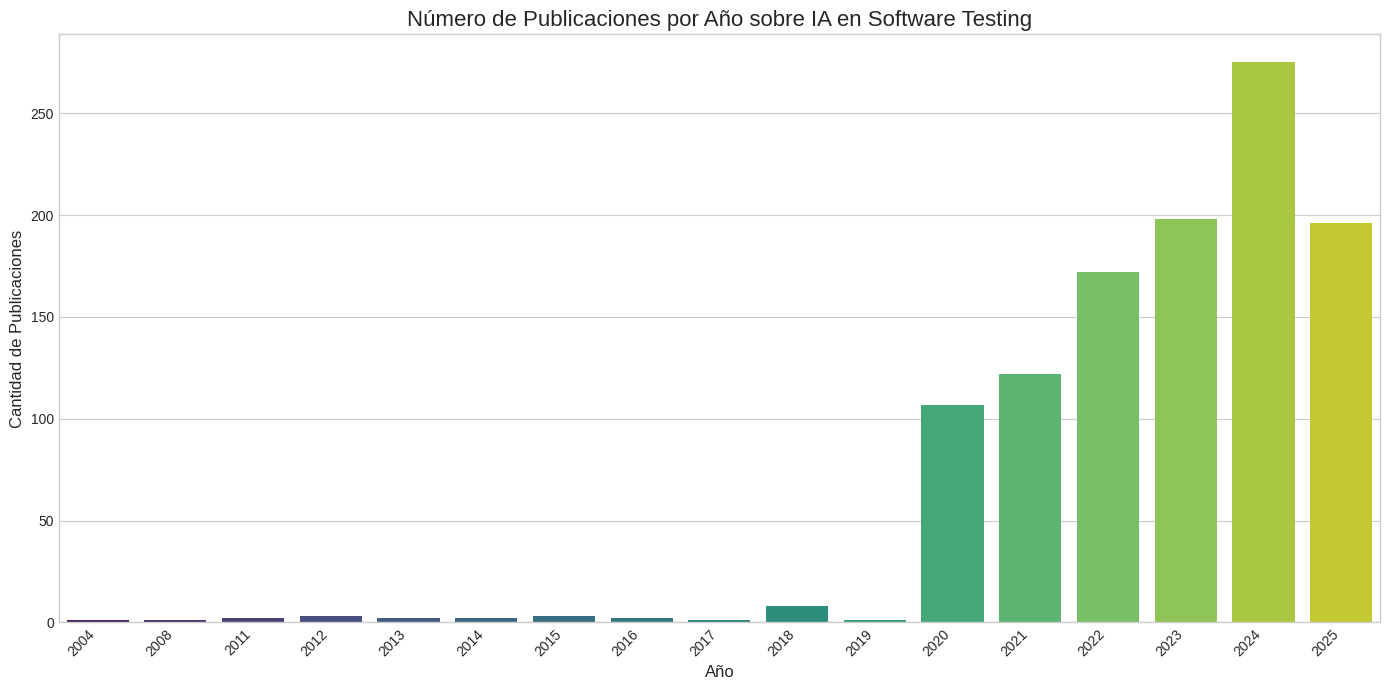

In [18]:
# Contar publicaciones por año y ordenarlas
publications_per_year = df['year'].value_counts().sort_index()

# Filtrar para mostrar desde el año 2000 para mayor claridad
publications_per_year = publications_per_year[publications_per_year.index >= 2000]

# Visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 7))
sns.barplot(x=publications_per_year.index, y=publications_per_year.values, palette="viridis")
plt.title('Número de Publicaciones por Año sobre IA en Software Testing', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad de Publicaciones', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

/tmp/ipykernel_3148928/3052633649.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_authors.values, y=top_authors.index, palette="mako_r", orient='h')


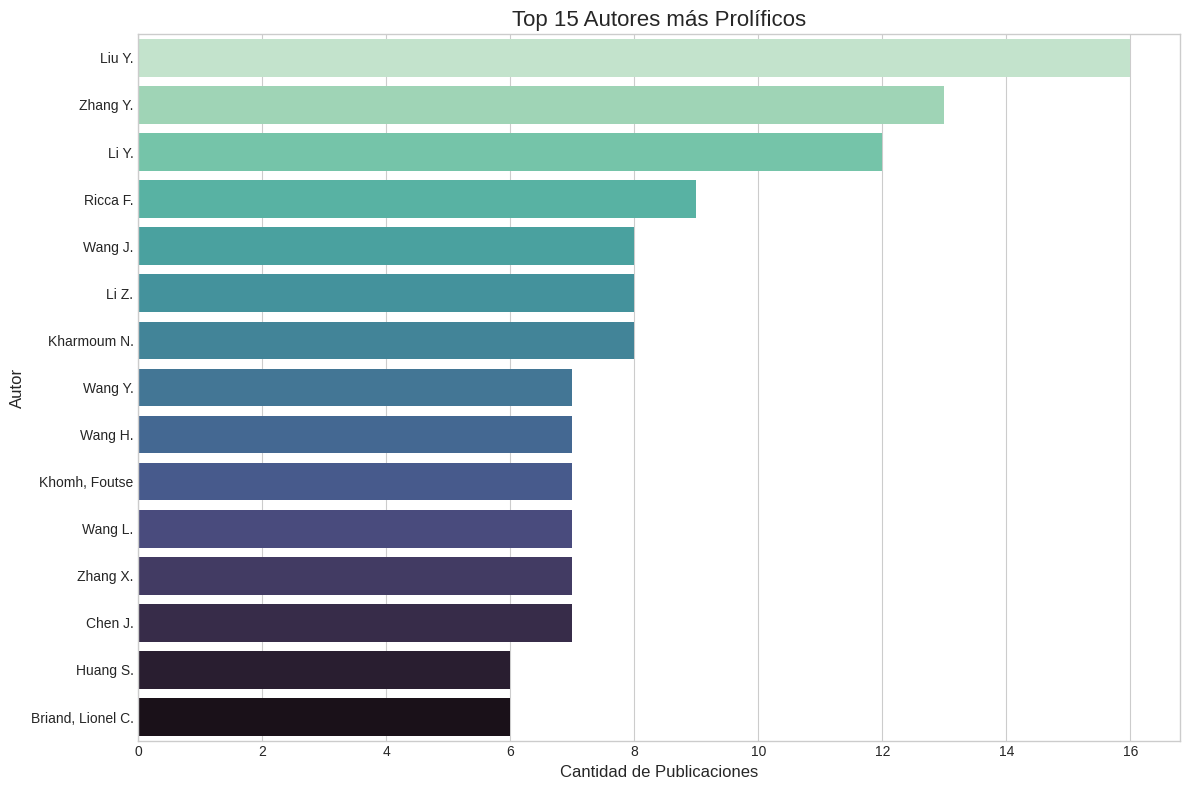

In [19]:
# Usamos 'explode' para crear una fila por cada autor en la lista 'authors_list'
authors_exploded = df.explode('authors_list')

# Contamos la frecuencia de cada autor y tomamos el top 15
top_authors = authors_exploded['authors_list'].value_counts().nlargest(15)

# Visualización
plt.figure(figsize=(12, 8))
sns.barplot(x=top_authors.values, y=top_authors.index, palette="mako_r", orient='h')
plt.title('Top 15 Autores más Prolíficos', fontsize=16)
plt.xlabel('Cantidad de Publicaciones', fontsize=12)
plt.ylabel('Autor', fontsize=12)
plt.tight_layout()
plt.show()


In [20]:
# Rellenar valores nulos en columnas clave para el análisis
df['authors'].fillna('Desconocido', inplace=True)
df['author_Keywords'].fillna('', inplace=True)
df['document_type'].fillna('No especificado', inplace=True)
df['source_title'].fillna('No especificado', inplace=True)


# --- 3. Estructurar Columnas para Análisis ---
# Crear listas a partir de cadenas separadas por ';'
def split_and_clean(text, delimiter=';'):
    if not isinstance(text, str):
        return []
    return [item.strip() for item in text.split(delimiter) if item.strip()]

df['authors_list'] = df['authors'].apply(split_and_clean)
df['keywords_list'] = df['author_Keywords'].apply(lambda x: [kw.lower() for kw in split_and_clean(x)])

print("\nPreparación de datos completada. ¡Listos para el EDA!")


Preparación de datos completada. ¡Listos para el EDA!


/tmp/ipykernel_3148928/3459095387.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['authors'].fillna('Desconocido', inplace=True)
/tmp/ipykernel_3148928/3459095387.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

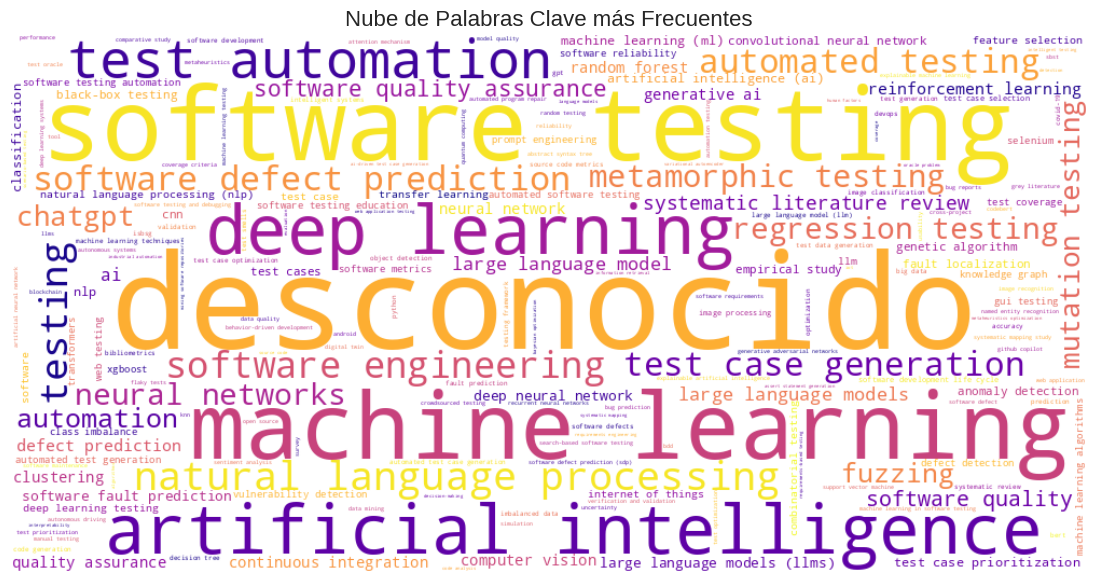

In [21]:
# Juntar todas las palabras clave en una sola lista
all_keywords = [kw for sublist in df['keywords_list'] for kw in sublist]

# Contar la frecuencia de cada palabra clave
keyword_counts = Counter(all_keywords)

# Generar la nube de palabras



wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='plasma').generate_from_frequencies(keyword_counts)

# Visualización
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras Clave más Frecuentes', fontsize=16)
plt.show()


/tmp/ipykernel_3148928/2708844536.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_sources.values, y=top_sources.index, palette="rocket_r", orient='h')


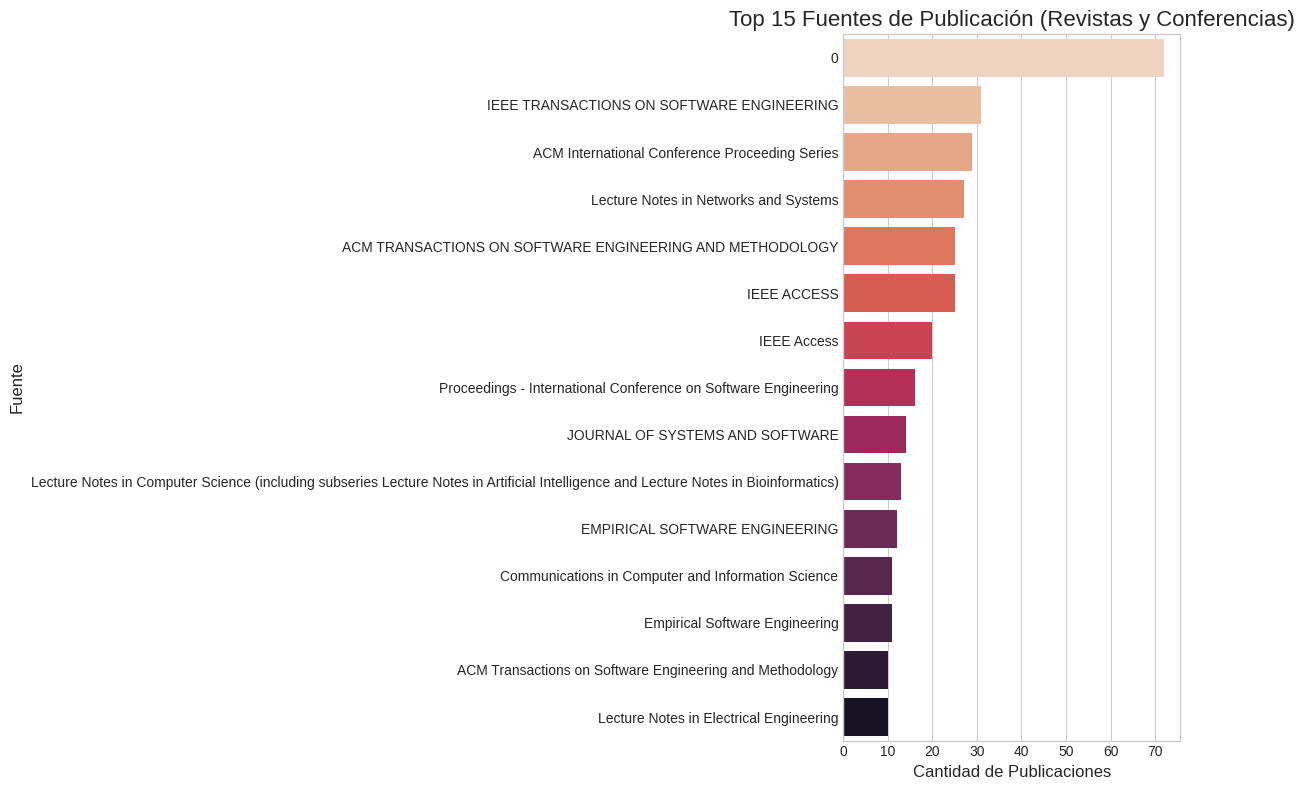

In [22]:
# Contar publicaciones por fuente y tomar el top 15
top_sources = df['source_title'].value_counts().nlargest(15)

# Visualización
plt.figure(figsize=(12, 8))
sns.barplot(x=top_sources.values, y=top_sources.index, palette="rocket_r", orient='h')
plt.title('Top 15 Fuentes de Publicación (Revistas y Conferencias)', fontsize=16)
plt.xlabel('Cantidad de Publicaciones', fontsize=12)
plt.ylabel('Fuente', fontsize=12)
plt.tight_layout()
plt.show()


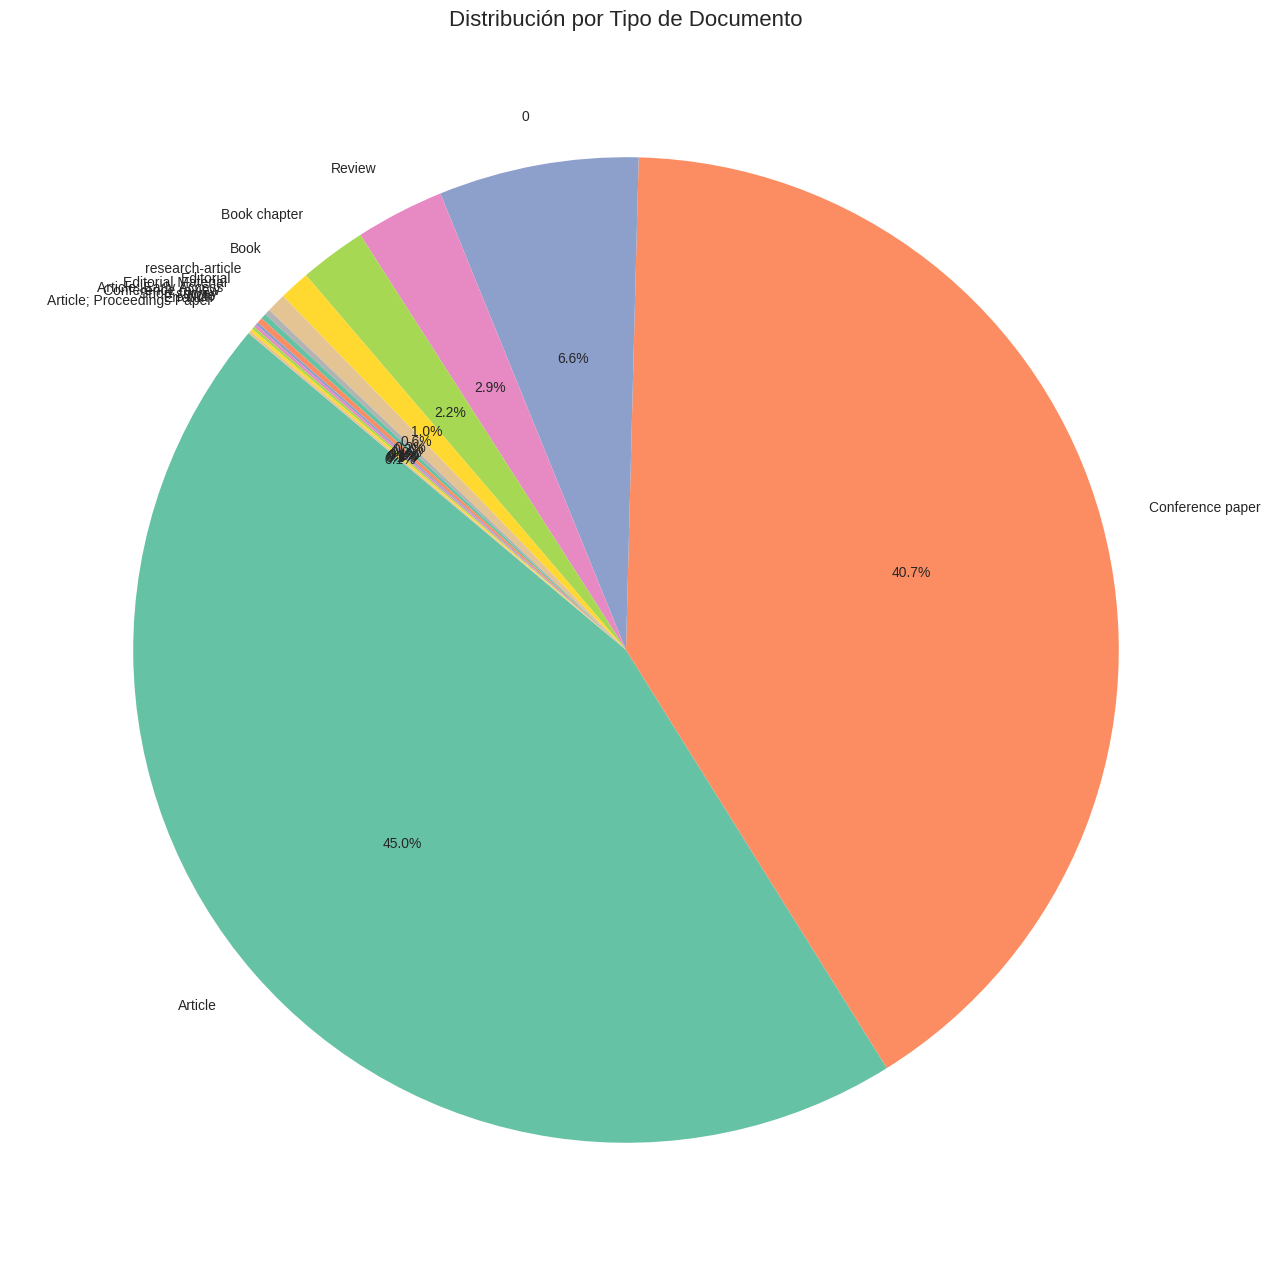

In [24]:
# Contar la frecuencia de cada tipo de documento
doc_types = df['document_type'].value_counts()

# Visualización
plt.figure(figsize=(24, 16))
plt.pie(doc_types, labels=doc_types.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
plt.title('Distribución por Tipo de Documento', fontsize=16)
plt.ylabel('') # Ocultar la etiqueta del eje y
plt.show()


In [25]:
# Lista para almacenar todas las aristas (pares de co-autores)
edge_list = []

# Iterar sobre cada lista de autores en el DataFrame
for authors in df['authors_list']:
    # Solo nos interesan las publicaciones con 2 o más autores
    if len(authors) > 1:
        # Generar todas las combinaciones de 2 autores
        # Usamos sorted() para que el par (Autor A, Autor B) sea igual a (Autor B, Autor A)
        links = combinations(sorted(authors), 2)
        edge_list.extend(links)

# Contar la frecuencia de cada colaboración (el peso de cada arista)
collaboration_counts = Counter(edge_list)

print(f"Se encontraron {len(collaboration_counts)} colaboraciones únicas.")
print("\nTop 10 colaboraciones más fuertes:")
print(collaboration_counts.most_common(10))


Se encontraron 7296 colaboraciones únicas.

Top 10 colaboraciones más fuertes:
[(('Marchetto A.', 'Ricca F.'), 5), (('Boukhlif M.', 'Hanine M.'), 5), (('Boukhlif M.', 'Kharmoum N.'), 5), (('Hanine M.', 'Kharmoum N.'), 5), (('Khomh, Foutse', 'Nikanjam, Amin'), 5), (('Leotta M.', 'Ricca F.'), 4), (('Ali S.', 'Yue T.'), 4), (('Hähner J.', 'Rosenbauer L.'), 4), (('Gotlieb A.', 'Spieker H.'), 4), (('Chen, Zhenyu', 'Fang, Chunrong'), 4)]


In [26]:
# Crear un grafo vacío
G = nx.Graph()

# Añadir las aristas con su peso (número de colaboraciones)
for (author1, author2), count in collaboration_counts.items():
    G.add_edge(author1, author2, weight=count)

print(f"\nGrafo creado con {G.number_of_nodes()} nodos (autores) y {G.number_of_edges()} aristas (colaboraciones).")



Grafo creado con 3184 nodos (autores) y 7296 aristas (colaboraciones).


In [27]:
# --- Filtrar para mantener solo el núcleo de la red ---
# 1. Calcular el número de publicaciones de cada autor
all_authors = [author for sublist in df['authors_list'] for author in sublist]
author_counts = Counter(all_authors)

# 2. Seleccionar los N autores más prolíficos (ej. top 50)
N_TOP_AUTHORS = 50
top_authors_list = [author for author, count in author_counts.most_common(N_TOP_AUTHORS)]

# 3. Crear un subgrafo que solo contenga a estos autores y las conexiones entre ellos
core_graph = G.subgraph(top_authors_list)

# 4. (Opcional pero recomendado) Mantener solo el componente conectado más grande para una mejor visualización
largest_cc = max(nx.connected_components(core_graph), key=len)
final_graph = core_graph.subgraph(largest_cc)

print(f"\nSubgrafo final para visualización con {final_graph.number_of_nodes()} autores y {final_graph.number_of_edges()} colaboraciones.")



Subgrafo final para visualización con 31 autores y 101 colaboraciones.


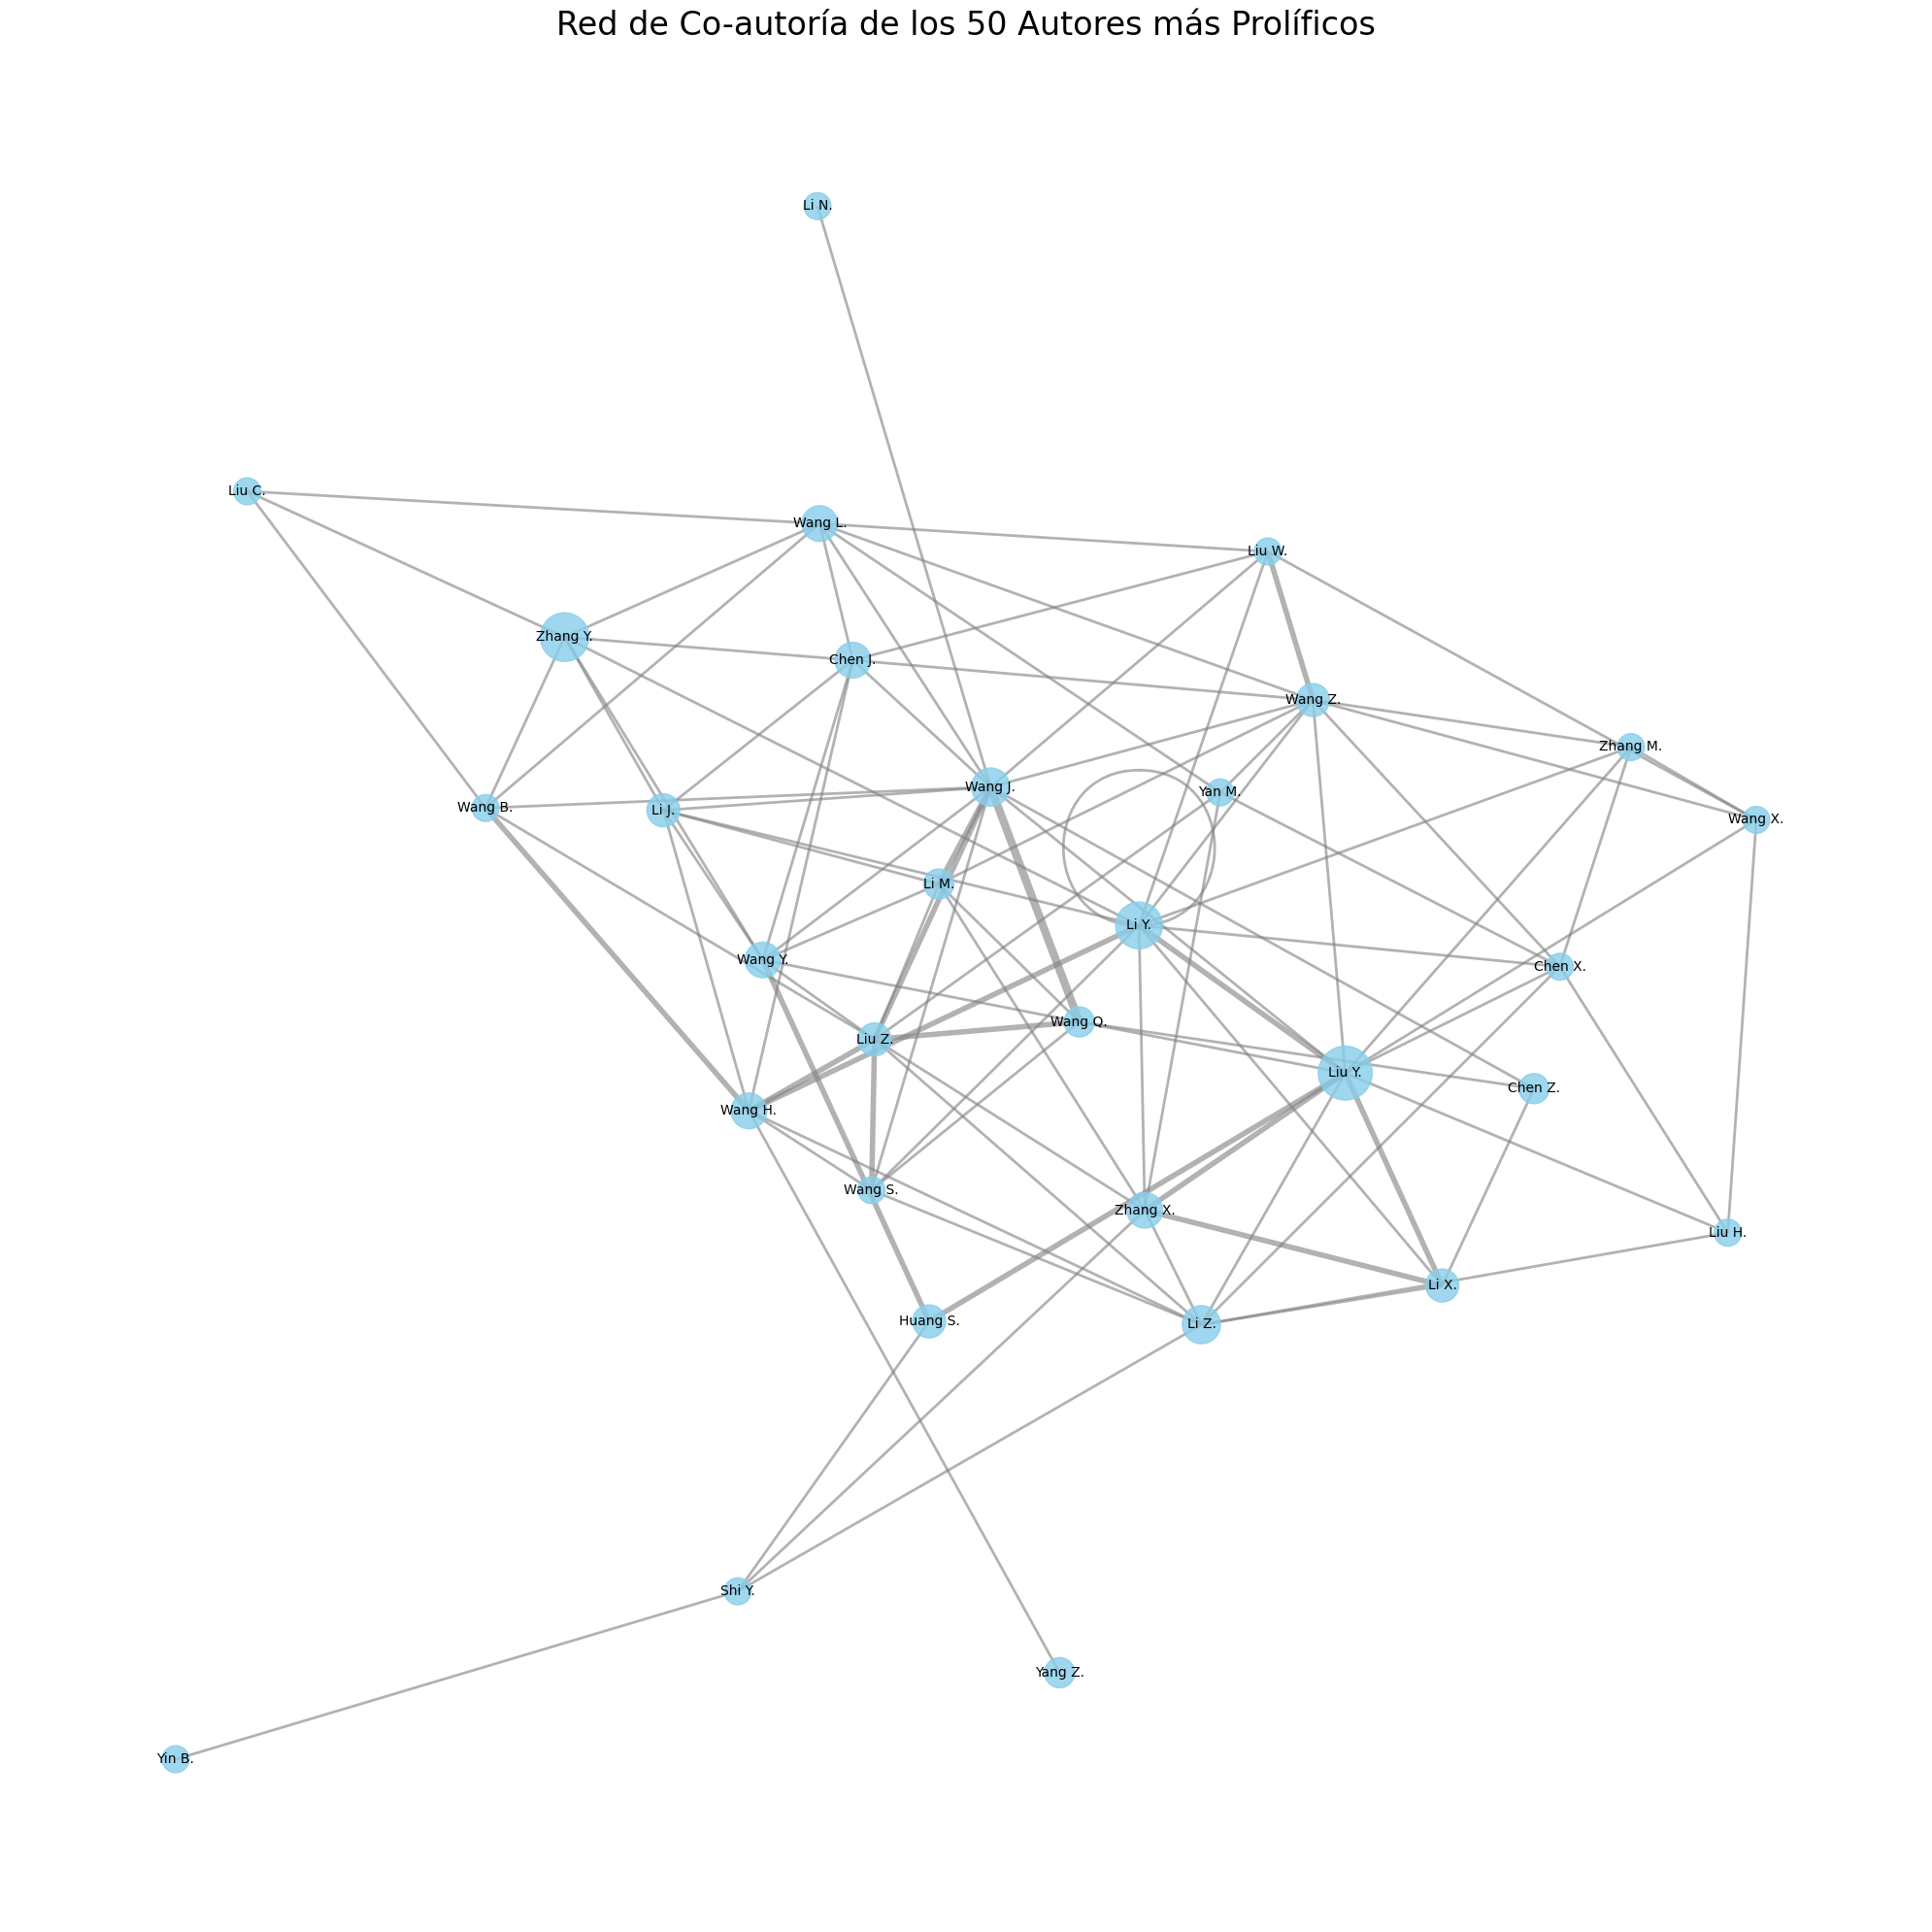

In [28]:
plt.style.use('default')
plt.figure(figsize=(20, 20))

# --- Posicionamiento de los nodos ---
# El layout "spring" simula una repulsión entre nodos y una atracción por las aristas
pos = nx.spring_layout(final_graph, k=0.6, iterations=50, seed=42)

# --- Dibujar los nodos ---
# El tamaño del nodo será proporcional a su número de publicaciones
node_sizes = [author_counts[node] * 100 for node in final_graph.nodes()]
nx.draw_networkx_nodes(final_graph, pos, node_size=node_sizes, node_color='skyblue', alpha=0.8)

# --- Dibujar las aristas ---
# El grosor de la arista será proporcional al número de colaboraciones
edge_weights = [final_graph[u][v]['weight'] * 2 for u, v in final_graph.edges()]
nx.draw_networkx_edges(final_graph, pos, width=edge_weights, edge_color='gray', alpha=0.6)

# --- Dibujar las etiquetas (nombres de los autores) ---
nx.draw_networkx_labels(final_graph, pos, font_size=10, font_family='sans-serif')

# --- Títulos y configuración del gráfico ---
plt.title('Red de Co-autoría de los 50 Autores más Prolíficos', fontsize=24)
plt.axis('off') # Ocultar los ejes
plt.tight_layout()
plt.show()


In [29]:
# Seleccionar y combinar las columnas de texto. Rellenar nulos con ''
df['title'] = df['title'].fillna('')
df['abstract'] = df['abstract'].fillna('')
df['documents'] = df['title'] + '. ' + df['abstract']

print(f"Dataset preparado con {len(df)} documentos únicos para el análisis LDA.")
print("\nEjemplo de documento combinado:")
print(df['documents'].iloc[1])

Dataset preparado con 1098 documentos únicos para el análisis LDA.

Ejemplo de documento combinado:
Top AI-powered tools for software test automation. As software systems become more complex, there is also an acute need for efficient, accurate, and scalable testing solutions. While traditional test automation is indeed quite powerful, it very often has to struggle against the demands of more advanced development environments that rely on continuous integration and delivery pipelines. We will compare these tools with a number of real-world case studies, underlining the improvements in how these tools enhance software quality and reduce the time-to-market along with the ability to perform continuous testing.Of course, we also touch upon the related issues when adopting AI-driven testing solutions-the challenges of data privacy and the integration complexity of new tools into existing workflows. By the end of this chapter, you will understand in clear-cut terms the main benefits and limit

In [30]:
nltk.download('wordnet')
# --- 2. Pre-procesamiento de Texto ---

# Inicializar lemmatizer y stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Añadir stopwords personalizadas que son muy comunes en este dominio
# y que no aportan a la diferenciación de tópicos.
custom_stopwords = {'software', 'testing', 'test', 'system', 'approach', 'method', 
                    'technique', 'paper', 'study', 'research', 'result', 'propose', 
                    'based', 'using', 'also', 'model', 'analysis', 'ai', 'artificial', 
                    'intelligence', 'application'}
stop_words.update(custom_stopwords)

def preprocess_text(text):
    # 1. Convertir a minúsculas
    text = text.lower()
    # 2. Eliminar caracteres no alfabéticos (puntuación, números, etc.)
    text = re.sub(r'[^a-z\s]', '', text)
    # 3. Tokenizar (dividir el texto en palabras)
    tokens = text.split()
    # 4. Lemmatizar y eliminar stopwords y palabras cortas
    lemmatized_tokens = [
        lemmatizer.lemmatize(token) for token in tokens 
        if token not in stop_words and len(token) > 2
    ]
    return lemmatized_tokens

# Aplicar la función de pre-procesamiento a todos los documentos
processed_docs = df['documents'].map(preprocess_text)

print("\nEjemplo de documento procesado (tokenizado y lemmatizado):")
print(processed_docs.iloc[1])


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/aalejoz25/nltk_data...



Ejemplo de documento procesado (tokenizado y lemmatizado):
['top', 'aipowered', 'tool', 'automation', 'system', 'become', 'complex', 'acute', 'need', 'efficient', 'accurate', 'scalable', 'solution', 'traditional', 'automation', 'indeed', 'quite', 'powerful', 'often', 'struggle', 'demand', 'advanced', 'development', 'environment', 'rely', 'continuous', 'integration', 'delivery', 'pipeline', 'compare', 'tool', 'number', 'realworld', 'case', 'study', 'underlining', 'improvement', 'tool', 'enhance', 'quality', 'reduce', 'timetomarket', 'along', 'ability', 'perform', 'continuous', 'testingof', 'course', 'touch', 'upon', 'related', 'issue', 'adopting', 'aidriven', 'solutionsthe', 'challenge', 'data', 'privacy', 'integration', 'complexity', 'new', 'tool', 'existing', 'workflow', 'end', 'chapter', 'understand', 'clearcut', 'term', 'main', 'benefit', 'limitation', 'scope', 'aipowered', 'tool', 'thus', 'making', 'better', 'decisionmakers', 'come', 'choosing', 'applying', 'technology', 'process'

In [31]:
# --- 3. Crear Diccionario y Corpus ---

# Crear un diccionario a partir de los documentos procesados
# El diccionario mapea cada palabra a un ID único.
dictionary = Dictionary(processed_docs)

# Filtrar palabras extremas:
# - no_below: ignora palabras que aparecen en menos de 5 documentos.
# - no_above: ignora palabras que aparecen en más del 50% de los documentos.
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Crear el corpus (Bolsa de Palabras)
# Convierte cada documento en una lista de tuplas (word_id, frequency).
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

print(f"\nDiccionario creado con {len(dictionary)} palabras únicas.")
print("Ejemplo de un documento en formato BoW (ID de palabra, frecuencia):")
print(corpus[1][:10]) # Muestra los primeros 10 pares



Diccionario creado con 2717 palabras únicas.
Ejemplo de un documento en formato BoW (ID de palabra, frecuencia):
[(5, 2), (9, 1), (11, 1), (20, 1), (21, 1), (77, 1), (95, 1), (98, 1), (99, 1), (111, 1)]


In [32]:
# --- 4. Construir el Modelo LDA ---

# Definir el número de tópicos a descubrir
num_topics = 8 

# Construir el modelo LDA
# passes: número de veces que el modelo itera sobre todo el corpus.
# iterations: número de iteraciones por documento.
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

print(f"\nModelo LDA entrenado con {num_topics} tópicos.")
print("\nTópicos descubiertos (palabras clave por tópico):")
for idx, topic in lda_model.print_topics(-1):
    print(f"Tópico: {idx+1} \nPalabras: {topic}\n")



Modelo LDA entrenado con 8 tópicos.

Tópicos descubiertos (palabras clave por tópico):
Tópico: 1 
Palabras: 0.023*"technique" + 0.016*"machine" + 0.016*"engineering" + 0.013*"application" + 0.012*"approach" + 0.012*"review" + 0.011*"data" + 0.011*"system" + 0.011*"quality" + 0.011*"study"

Tópico: 2 
Palabras: 0.020*"automated" + 0.019*"development" + 0.018*"framework" + 0.018*"automation" + 0.014*"challenge" + 0.013*"tool" + 0.012*"process" + 0.011*"environment" + 0.010*"user" + 0.010*"integration"

Tópico: 3 
Palabras: 0.015*"system" + 0.013*"deep" + 0.011*"network" + 0.010*"coverage" + 0.010*"input" + 0.009*"model" + 0.009*"result" + 0.009*"data" + 0.008*"program" + 0.007*"generation"

Tópico: 4 
Palabras: 0.034*"web" + 0.030*"gui" + 0.022*"case" + 0.017*"application" + 0.017*"fuzzing" + 0.017*"generation" + 0.015*"element" + 0.014*"user" + 0.014*"language" + 0.014*"knowledge"

Tópico: 5 
Palabras: 0.081*"prediction" + 0.070*"defect" + 0.040*"fault" + 0.031*"model" + 0.026*"feature

In [27]:
# --- 5. Visualización de los Tópicos ---

# Habilitar el formateador de pyLDAvis para notebooks (si usas uno)
pyLDAvis.enable_notebook()

# Preparar los datos para la visualización
# NOTA: El cálculo puede tardar unos minutos en datasets grandes.
vis_data = gensimvis.prepare(lda_model, corpus, dictionary, mds='mmds')

# Guardar la visualización en un archivo HTML
output_filepath = '/home/cristian/analisis_rsl/LDA_resultados.html'
pyLDAvis.save_html(vis_data, output_filepath)

print(f"\n¡Visualización LDA guardada en '{output_filepath}'!")
print("Abre este archivo en tu navegador para explorar los tópicos de forma interactiva.")

# Mostrar la visualización directamente (si estás en un Jupyter Notebook/Lab)
vis_data


/home/cristian/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=210987) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/cristian/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=210987) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/cristian/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=210987) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/cristian/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=210987) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/cristian/anaconda3/lib/python3.12/site-packages/joblib/ext


¡Visualización LDA guardada en '/home/cristian/analisis_rsl/LDA_resultados.html'!
Abre este archivo en tu navegador para explorar los tópicos de forma interactiva.


/home/cristian/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.246282  0.187200       1        1  23.423394
2      0.052885  0.308666       2        1  18.972307
1      0.131226 -0.240142       3        1  17.688064
5     -0.067742  0.005295       4        1  16.377615
6     -0.077893 -0.332553       5        1  13.480971
4      0.379710 -0.115481       6        1   5.172492
3     -0.272638  0.301178       7        1   3.078612
0     -0.391831 -0.114164       8        1   1.806545, topic_info=            Term         Freq        Total Category  logprob  loglift
20          data  1011.000000  1011.000000  Default  30.0000  30.0000
900   prediction   665.000000   665.000000  Default  29.0000  29.0000
9           case  1037.000000  1037.000000  Default  28.0000  28.0000
71       network   368.000000   368.000000  Default  27.0000  27.0000
663       defect   576.000000   576.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1809         may    25.226907   198.098725   Topic8  -4.4239   1.9529
1952      object    19.347279    77.688243   Topic8  -4.6893   2.6236
722       always    15.786107    25.447173   Topic8  -4.8927   3.5363
771    criterion    17.920922   100.941674   Topic8  -4.7659   2.2852
324     accuracy    17.035756   359.972881   Topic8  -4.8165   0.9630

[469 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
324       2  0.011112  accuracy
324       3  0.605601  accuracy
324       4  0.086118  accuracy
324       5  0.002778  accuracy
324       6  0.244463  accuracy
...     ...       ...       ...
321       2  0.235731      work
321       3  0.105908      work
321       4  0.034164      work
321       5  0.174236      work
176       2  0.986768  workflow

[780 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 3, 2, 6, 7, 5, 4, 1])

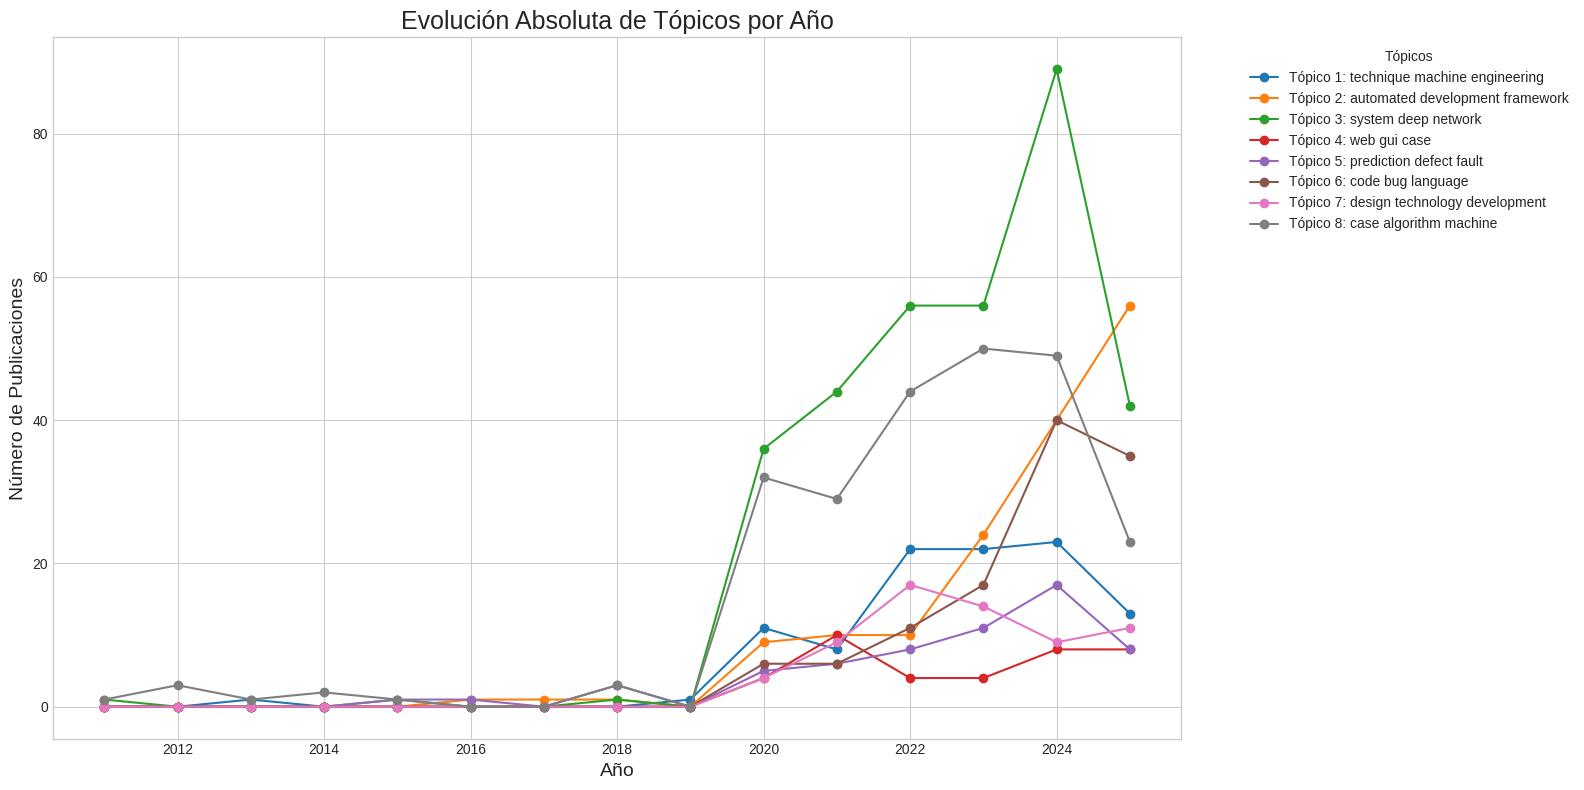

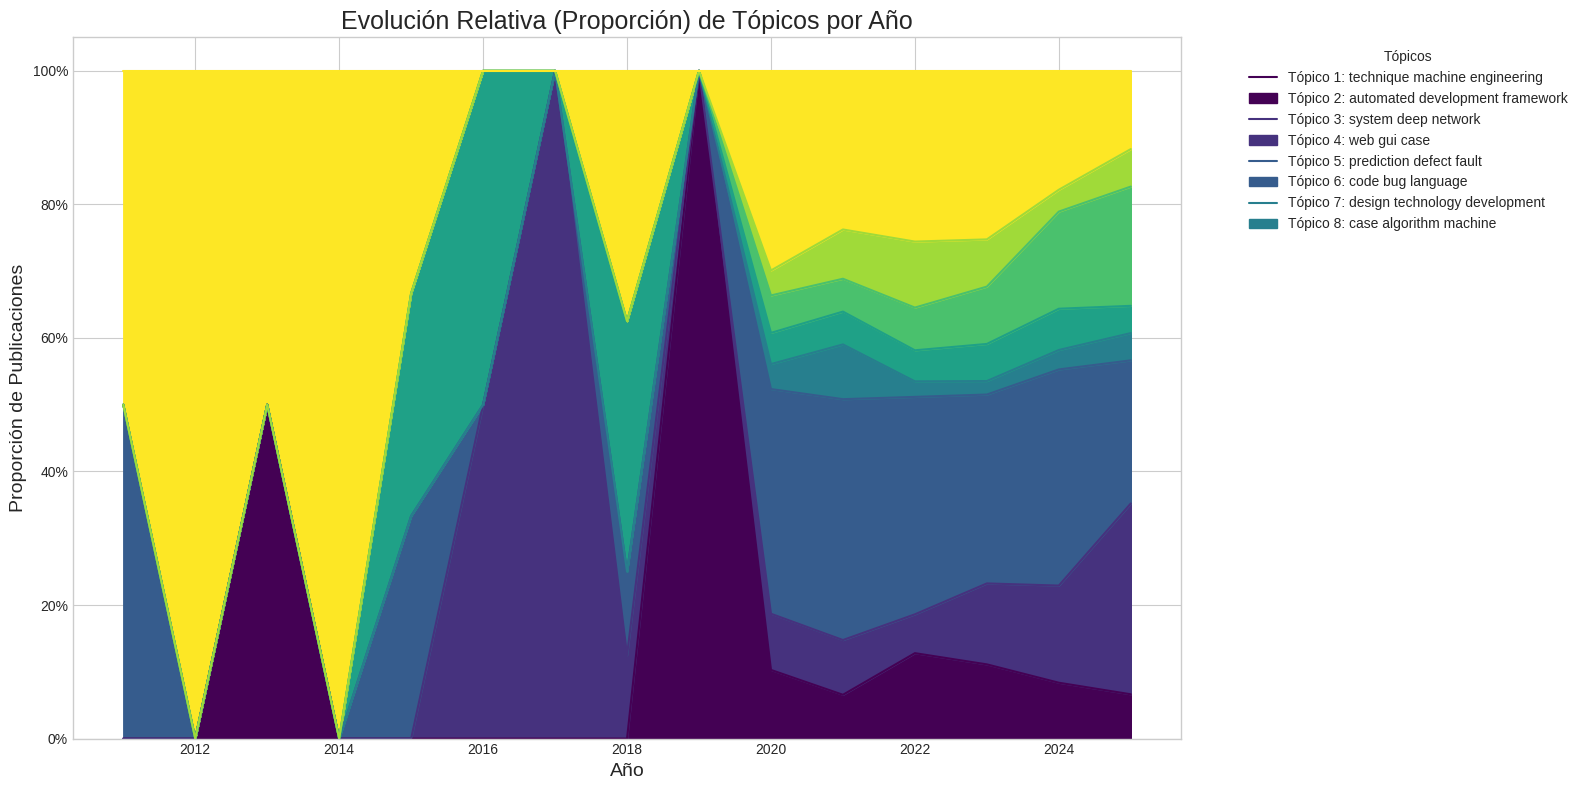

In [33]:
# --- 3. Asignar Tópico Dominante a cada Documento ---
def get_dominant_topic(bow):
    # Obtener la distribución de tópicos para un documento
    topic_distribution = lda_model.get_document_topics(bow, minimum_probability=0.0)
    # Ordenar por probabilidad y obtener el tópico con la más alta
    dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0]
    return dominant_topic[0]

# Crear una nueva columna en el DataFrame con el tópico dominante
# Asegurarse de que los índices coincidan después de haber eliminado filas nulas
df['dominant_topic'] = [get_dominant_topic(corpus[i]) for i in range(len(corpus))]

# --- 4. Agrupar por Año y Tópico ---
# Filtrar por un rango de años para una mejor visualización (ej. desde el 2010)
df_filtered = df[df['year'] >= 2010]

# Agrupar por año y tópico dominante, y contar el número de documentos
topic_counts_per_year = df_filtered.groupby(['year', 'dominant_topic']).size().unstack(fill_value=0)

# --- 5. Visualizar la Evolución de los Tópicos ---

# Gráfico 1: Evolución de la popularidad absoluta (número de publicaciones)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 8))
topic_counts_per_year.plot(ax=ax, marker='o', linestyle='-')

# Crear etiquetas de leyenda más descriptivas
topic_keywords = [" ".join([word for word, _ in lda_model.show_topic(i, topn=3)]) for i in range(num_topics)]
legend_labels = [f'Tópico {i+1}: {topic_keywords[i]}' for i in range(num_topics)]

ax.set_title('Evolución Absoluta de Tópicos por Año', fontsize=18)
ax.set_xlabel('Año', fontsize=14)
ax.set_ylabel('Número de Publicaciones', fontsize=14)
ax.legend(legend_labels, title='Tópicos', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Gráfico 2: Evolución de la popularidad relativa (proporción de publicaciones)
# Normalizar los datos para que cada fila sume 1 (100%)
topic_proportions = topic_counts_per_year.div(topic_counts_per_year.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(16, 8))
topic_proportions.plot(kind='area', stacked=True, ax=ax, colormap='viridis')

ax.set_title('Evolución Relativa (Proporción) de Tópicos por Año', fontsize=18)
ax.set_xlabel('Año', fontsize=14)
ax.set_ylabel('Proporción de Publicaciones', fontsize=14)
ax.legend(legend_labels, title='Tópicos', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format)) # Formatear eje Y como porcentaje
plt.tight_layout()
plt.show()

Datos listos para la creación de la red de co-ocurrencia de palabras clave.

Se encontraron 6680 pares de co-ocurrencia únicos.

Top 10 co-ocurrencias más fuertes:
[(('machine learning', 'test automation'), 14), (('deep learning', 'machine learning'), 11), (('machine learning', 'natural language processing'), 9), (('machine learning', 'software defect prediction'), 8), (('machine learning', 'testing'), 8), (('automation', 'machine learning'), 8), (('automated testing', 'machine learning'), 7), (('machine learning', 'random forest'), 6), (('deep learning', 'neural networks'), 6), (('regression testing', 'test case prioritization'), 5)]

Grafo final para visualización con 39 nodos y 176 aristas.


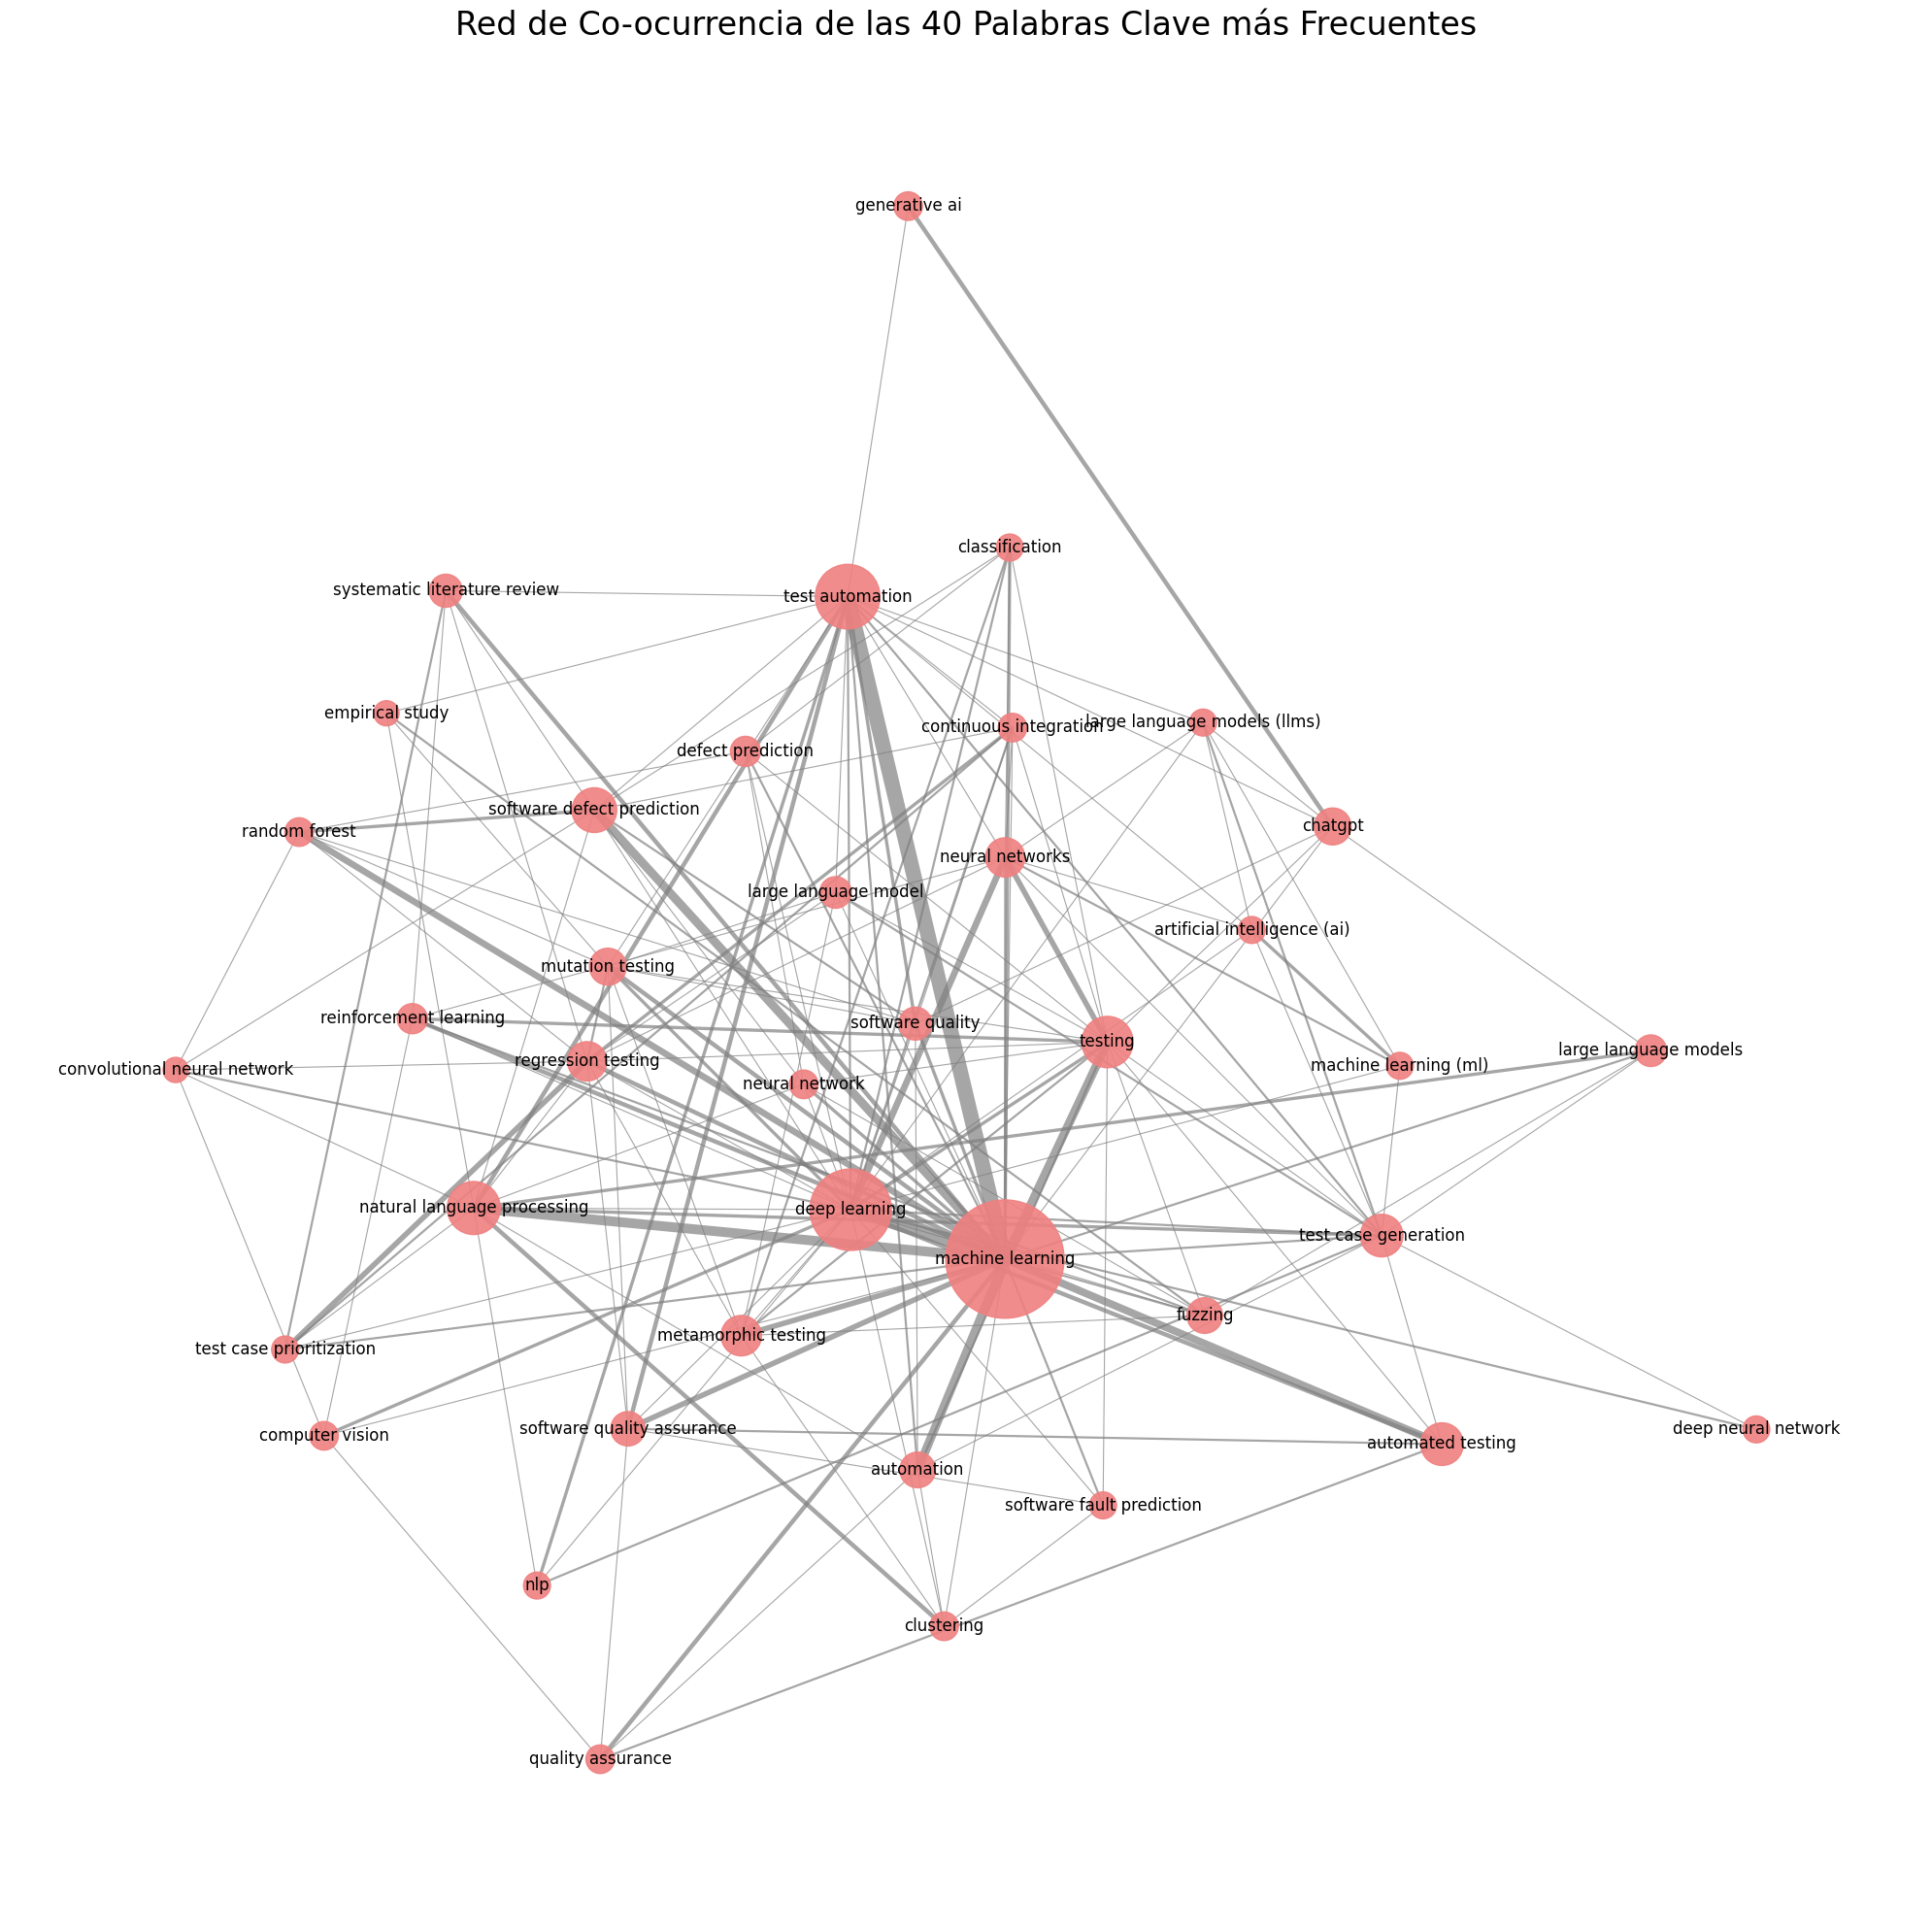

In [35]:
# --- 2. Procesamiento de Palabras Clave ---
def split_and_clean(text, delimiter=';'):
    if not isinstance(text, str):
        return []
    # Limpiamos, convertimos a minúsculas y eliminamos palabras clave genéricas
    keywords = [item.strip().lower() for item in text.split(delimiter) if item.strip()]
    # Filtramos palabras clave muy genéricas que no aportan valor a la red
    generic_kws = {'software testing', 'artificial intelligence', 'ai', 'software engineering'}
    return [kw for kw in keywords if kw not in generic_kws]

df['keywords_list'] = df['author_Keywords'].apply(split_and_clean)

print("Datos listos para la creación de la red de co-ocurrencia de palabras clave.")

# --- 3. Generación de Pares de Co-ocurrencia ---
# Lista para almacenar todos los pares de palabras clave que co-ocurren
co_occurrence_pairs = []

for keywords in df['keywords_list']:
    # Solo nos interesan publicaciones con 2 o más palabras clave
    if len(keywords) > 1:
        # Generar todas las combinaciones de 2 palabras clave
        # Usamos sorted() para que el par (A, B) sea igual a (B, A)
        links = combinations(sorted(keywords), 2)
        co_occurrence_pairs.extend(links)

# Contar la frecuencia de cada par (el peso de cada arista)
pair_counts = Counter(co_occurrence_pairs)

print(f"\nSe encontraron {len(pair_counts)} pares de co-ocurrencia únicos.")
print("\nTop 10 co-ocurrencias más fuertes:")
print(pair_counts.most_common(10))

# --- 4. Filtrado y Construcción del Grafo ---
# Contar la frecuencia de cada palabra clave individualmente
all_keywords = [kw for sublist in df['keywords_list'] for kw in sublist]
keyword_counts = Counter(all_keywords)

# Seleccionar las N palabras clave más frecuentes (ej. top 40)
N_TOP_KEYWORDS = 40
top_keywords_list = [kw for kw, count in keyword_counts.most_common(N_TOP_KEYWORDS)]

# Crear el grafo
G = nx.Graph()

# Añadir nodos y aristas ponderadas para las palabras clave del top
for (kw1, kw2), weight in pair_counts.items():
    if kw1 in top_keywords_list and kw2 in top_keywords_list:
        G.add_node(kw1, size=keyword_counts[kw1])
        G.add_node(kw2, size=keyword_counts[kw2])
        G.add_edge(kw1, kw2, weight=weight)

print(f"\nGrafo final para visualización con {G.number_of_nodes()} nodos y {G.number_of_edges()} aristas.")

# --- 5. Visualización de la Red ---
plt.style.use('default')
plt.figure(figsize=(20, 20))

# Layout para posicionar los nodos
pos = nx.kamada_kawai_layout(G)

# Tamaños de los nodos proporcionales a su frecuencia
node_sizes = [data['size'] * 50 for node, data in G.nodes(data=True)]

# Grosor de las aristas proporcional a su peso (frecuencia de co-ocurrencia)
edge_widths = [d['weight'] * 0.8 for (u, v, d) in G.edges(data=True)]

# Dibujar la red
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightcoral', alpha=0.9)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='grey', alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

plt.title('Red de Co-ocurrencia de las 40 Palabras Clave más Frecuentes', fontsize=24)
plt.axis('off')
plt.tight_layout()
plt.show()

In [36]:
# --- 3. Asignar Tópico Dominante a cada Documento ---
def get_dominant_topic_for_doc(doc_bow):
    # Obtener la distribución de tópicos para un documento
    topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
    # Encontrar el tópico con la probabilidad más alta
    dominant_topic = max(topic_distribution, key=lambda x: x[1])
    return dominant_topic[0] # Devolver solo el ID del tópico

# Aplicar la función a todo el corpus para obtener el tópico dominante de cada documento
dominant_topics = [get_dominant_topic_for_doc(doc) for doc in corpus]

# Añadir la columna de tópico dominante al DataFrame
df['dominant_topic'] = dominant_topics

print("Asignación completada. Mostrando DOIs por tópico:")

# --- 4. Mostrar DOIs y Títulos para cada Tópico ---
for topic_id in range(num_topics):
    print("\n" + "="*50)
    print(f"TÓPICO #{topic_id + 1}")
    print("="*50)
    
    # Obtener y mostrar las palabras clave del tópico
    keywords = lda_model.show_topic(topic_id, topn=10)
    topic_keywords = ", ".join([word for word, prop in keywords])
    print(f"Palabras Clave: {topic_keywords}\n")
    
    # Filtrar el DataFrame para este tópico y mostrar una muestra
    topic_df = df[df['dominant_topic'] == topic_id]
    
    # Tomar una muestra de hasta 5 artículos para no saturar la salida
    sample_size = min(5, len(topic_df))
    if sample_size > 0:
        sample_articles = topic_df.sample(n=sample_size, random_state=42)
        print("Artículos de ejemplo en este tópico:")
        for index, row in sample_articles.iterrows():
            print(f"  - DOI: {row['DOI']}")
            print(f"    Título: {row['title']}")
    else:
        print("No se encontraron artículos dominantes para este tópico.")

Asignación completada. Mostrando DOIs por tópico:

TÓPICO #1
Palabras Clave: technique, machine, engineering, application, approach, review, data, system, quality, study

Artículos de ejemplo en este tópico:
  - DOI: 10.1109/QRS-C63300.2024.00049
    Título: Testing and Reinforcement Learning - A Structured Literature Review
  - DOI: 10.1109/ICCCNT51525.2021.9580012
    Título: Intelligent Testing in Software Industry
  - DOI: 10.1007/978-3-030-91452-3_19
    Título: Towards a Common Testing Terminology for Software Engineering and Data Science Experts
  - DOI: 10.3390/su141711084
    Título: Determining the Factors Affecting a Career Shifter’s Use of Software Testing Tools amidst the COVID-19 Crisis in the Philippines: TTF-TAM Approach
  - DOI: 10.1049/cit2.12237
    Título: Deep learning's fitness for purpose: A transformation problem frame's perspective

TÓPICO #2
Palabras Clave: automated, development, framework, automation, challenge, tool, process, environment, user, integration


/tmp/ipykernel_3148928/1068742940.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=topic_distribution_counts.index, y=topic_distribution_counts.values, palette="cubehelix")
/tmp/ipykernel_3148928/1068742940.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(topic_labels, rotation=0, ha="center", fontsize=10)


[Text(0, 0, 'Tópico 1\ntechnique, machine, engineering, application'),
 Text(1, 0, 'Tópico 2\nautomated, development, framework, automation'),
 Text(2, 0, 'Tópico 3\nsystem, deep, network, coverage'),
 Text(3, 0, 'Tópico 4\nweb, gui, case, application'),
 Text(4, 0, 'Tópico 5\nprediction, defect, fault, model'),
 Text(5, 0, 'Tópico 6\ncode, bug, language, report'),
 Text(6, 0, 'Tópico 7\ndesign, technology, development, security'),
 Text(7, 0, 'Tópico 8\ncase, algorithm, machine, result')]

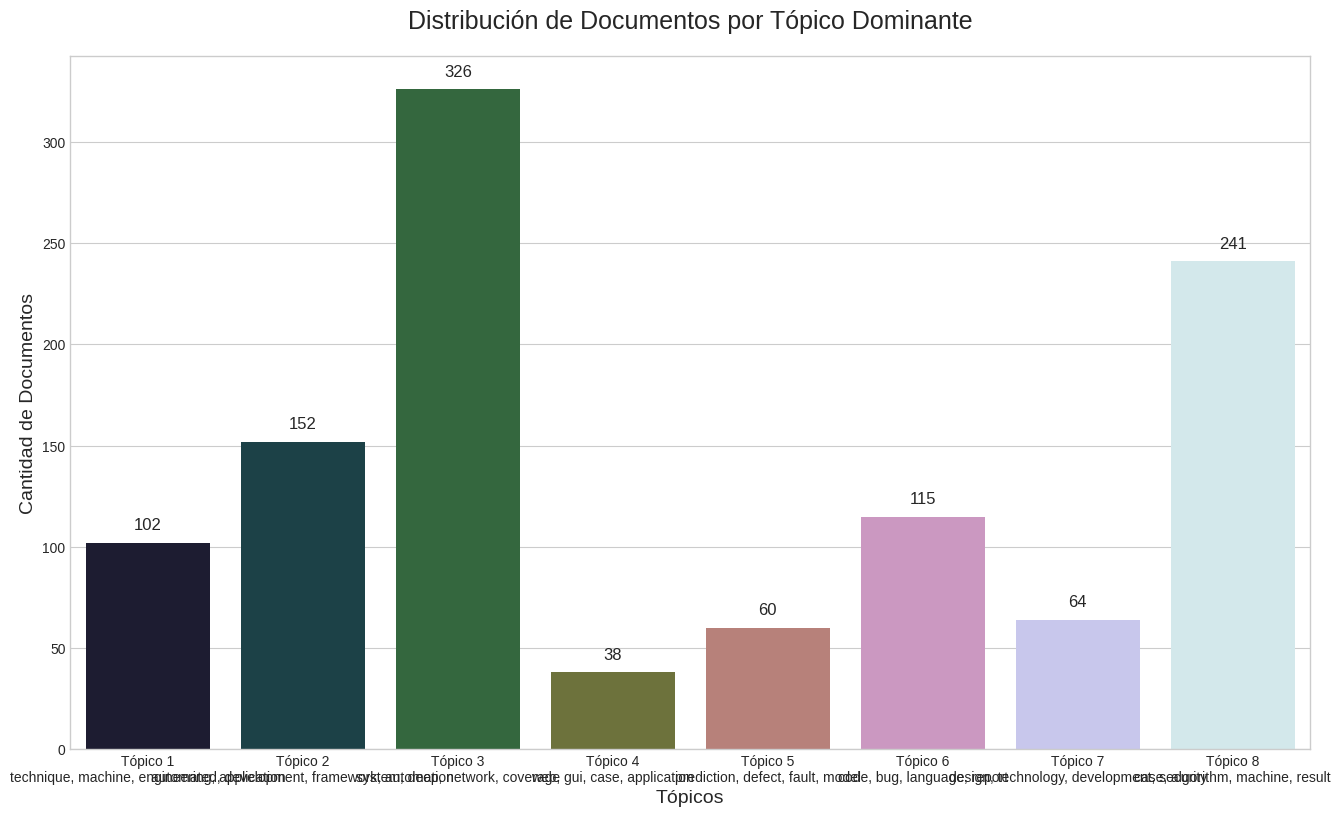

In [37]:
# --- 4. Contar Documentos por Tópico y Crear Gráfico ---

# Contar el número de documentos para cada tópico
topic_distribution_counts = df['dominant_topic'].value_counts().sort_index()

# Crear etiquetas más descriptivas para cada tópico
topic_labels = []
for i in range(num_topics):
    # Obtener las 4 palabras clave más importantes para el tópico i
    keywords = lda_model.show_topic(i, topn=4)
    # Formatear las palabras clave en una cadena
    label = f"Tópico {i+1}\n" + ", ".join([word for word, prop in keywords])
    topic_labels.append(label)

# Visualización del gráfico de barras
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 9))

ax = sns.barplot(x=topic_distribution_counts.index, y=topic_distribution_counts.values, palette="cubehelix")

# Añadir el número de documentos encima de cada barra
for index, value in enumerate(topic_distribution_counts.values):
    ax.text(index, value + 5, str(value), ha='center', va='bottom', fontsize=12)

plt.title('Distribución de Documentos por Tópico Dominante', fontsize=18, pad=20)
plt.xlabel('Tópicos', fontsize=14)
plt.ylabel('Cantidad de Documentos', fontsize=14)
ax.set_xticklabels(topic_labels, rotation=0, ha="center", fontsize=10)

In [38]:
#--- 3. Asignar Tópico Dominante y Probabilidad a cada Documento ---

def get_dominant_topic_and_prob(doc_bow):
    # Obtener la distribución de tópicos para un documento
    topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
    # Encontrar el tópico con la probabilidad más alta
    dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0]
    topic_id = dominant_topic[0]
    topic_prob = dominant_topic[1]
    return topic_id, topic_prob

# Aplicar la función a todo el corpus para obtener el tópico dominante y su probabilidad
# Usamos zip(*...) para separar las dos listas (IDs y probabilidades)
dominant_topics, topic_probabilities = zip(*[get_dominant_topic_and_prob(doc) for doc in corpus])

# --- 4. Añadir las Nuevas Columnas al DataFrame ---
df['dominant_topic'] = dominant_topics
df['topic_probability'] = topic_probabilities

print("Columnas 'dominant_topic' y 'topic_probability' añadidas.")

# --- 5. (Opcional pero recomendado) Crear una columna con etiquetas legibles ---
# Crear un diccionario para mapear el ID del tópico a un nombre descriptivo
topic_labels = {}
for i in range(num_topics):
    # Tomar las 3 palabras clave más importantes para el tópico i
    keywords = lda_model.show_topic(i, topn=3)
    # Formatear las palabras clave en una cadena legible
    label = f"Tópico {i+1}: " + ", ".join([word for word, prop in keywords])
    topic_labels[i] = label

# Mapear los IDs a las etiquetas legibles
df['topic_label'] = df['dominant_topic'].map(topic_labels)
print("Columna 'topic_label' con nombres descriptivos añadida.")


# --- 6. Mostrar el resultado ---
print("\n--- Vista previa del DataFrame con las nuevas columnas ---")
# Mostramos las columnas relevantes para verificar el resultado
print(df[['title', 'dominant_topic', 'topic_probability', 'topic_label']].head(10))

# También puedes ver la distribución de documentos por tópico
print("\n--- Distribución de documentos por tópico ---")
print(df['topic_label'].value_counts())

Columnas 'dominant_topic' y 'topic_probability' añadidas.
Columna 'topic_label' con nombres descriptivos añadida.

--- Vista previa del DataFrame con las nuevas columnas ---
                                               title  dominant_topic  \
0  Future of Information and Communication Confer...               1   
1  Top AI-powered tools for software test automation               0   
2  AI-Based Automotive Test Case Generation: An A...               1   
3  Exploration of experimental teaching mode of s...               5   
4  The qualitative factor in software testing: A ...               0   
5        Artificial intelligence in software testing               1   
6  Technology adoption performance evaluation app...               6   
7  Predicting Test Smell Categories based on Issu...               5   
8  Test Case Optimization using Machine Learning ...               7   
9  A Novel Machine Learning-Driven Approach to Hi...               2   

   topic_probability             

In [40]:
# --- 4. Exportar el DataFrame a CSV y XLSX ---

# Opción 1: Exportar a CSV
# Es rápido y bueno para la compatibilidad. Usaremos '|' como separador.
csv_output_path = './referencias_con_topicos.csv'
try:
    df.to_csv(csv_output_path, sep='|', index=False, encoding='utf-8')
    print(f"\n¡Éxito! DataFrame exportado a CSV en: {csv_output_path}")
except Exception as e:
    print(f"\nOcurrió un error al guardar en CSV: {e}")


# Opción 2: Exportar a Excel (XLSX)
# Es más amigable para visualizar, pero puede generar archivos grandes.
# Nota: Necesitarás instalar la librería openpyxl: pip install openpyxl
xlsx_output_path = './referencias_con_topicos.xlsx'
try:
    # Para evitar archivos muy grandes, es buena idea seleccionar las columnas más importantes.
    # Si quieres todas las columnas, simplemente usa df.to_excel(...)
    columns_to_export = [
        'DOI', 'title', 'authors', 'year', 'source_title', 
        'dominant_topic', 'topic_probability', 'topic_label', 'abstract'
    ]
    
    df_to_export = df[columns_to_export]
    df_to_export.to_excel(xlsx_output_path, index=False, engine='openpyxl')
    print(f"¡Éxito! DataFrame exportado a Excel en: {xlsx_output_path}")
except ImportError:
    print("\nPara exportar a Excel, por favor instala la librería 'openpyxl' ejecutando: pip install openpyxl")
except Exception as e:
    print(f"\nOcurrió un error al guardar en Excel: {e}")


¡Éxito! DataFrame exportado a CSV en: ./referencias_con_topicos.csv
¡Éxito! DataFrame exportado a Excel en: ./referencias_con_topicos.xlsx


# Analisis descriptivo y bibliometrico

In [41]:
# validaciones 
sns.set(style="whitegrid", rc={"figure.dpi":150})

# Asegurar columnas mínimas (si faltan, crearlas vacías para evitar errores)
for c in ["fuente","authors","author_full_names","title","year","source_title","cited_by",
          "DOI","abstract","author_Keywords","index_keywords","document_type","open_access"]:
    if c not in df.columns:
        df[c] = np.nan

# info rápida
print("Registros:", df.shape[0])

Registros: 1098


In [42]:
df[["title","year","source_title"]].head(5)

,title,year,source_title
0,Future of Information and Communication Confer...,2025,Lecture Notes in Networks and Systems
1,Top AI-powered tools for software test automation,2025,Artificial Intelligence for Cloud-Native Softw...
2,AI-Based Automotive Test Case Generation: An A...,2025,Lecture Notes in Computer Science (including s...
3,Exploration of experimental teaching mode of s...,2025,Discover Artificial Intelligence
4,The qualitative factor in software testing: A ...,2025,Journal of Systems and Software


In [43]:
print(df.isnull().sum().sort_values(ascending=False).head(20))

fuente                     0
authors_list               0
open_access                0
source                     0
EID                        0
title_cleaned              0
abstract_cleaned           0
author_Keywords_cleaned    0
index_keywords_cleaned     0
author_full_names_list     0
authors                    0
Author_ID_list             0
author_Keywords_list       0
index_keywords_list        0
keywords_list              0
documents                  0
dominant_topic             0
topic_probability          0
publication_stage          0
document_type              0
dtype: int64


In [44]:
# calidad de metadatos
# Un resumen rápido
print(df.describe(include='all').T[['count','unique']].head(30))

                          count  unique
fuente                     1098       4
authors                    1098    1074
author_full_names        1098.0   752.0
Author_ID                1098.0   751.0
title                      1098    1090
year                     1098.0     NaN
source_title             1098.0   538.0
volume                   1098.0   273.0
issue                    1098.0    31.0
art                      1098.0   296.0
page_start               1098.0   511.0
page_end                 1098.0   523.0
page_count               1098.0     NaN
cited_by                 1098.0     NaN
DOI                      1098.0  1098.0
link                     1098.0   840.0
abstract                   1098    1096
author_Keywords            1098     749
index_keywords             1098     660
document_type              1098      15
publication_stage          1098       3
open_access              1098.0     9.0
source                     1098       2
EID                      1098.0   768.0


In [45]:
# % de registros con DOI/abstract/keywords
for col in ["DOI","abstract","author_Keywords","author_full_names"]:
    pct = df[col].notna().sum()/len(df)*100
    print(f"{col}: {df[col].notna().sum()} ({pct:.1f}%)")

DOI: 1098 (100.0%)
abstract: 1098 (100.0%)
author_Keywords: 1098 (100.0%)
author_full_names: 1098 (100.0%)


In [46]:
#fuente
# Preferir 'source_title' si está, sino 'fuente'
src_col = "source_title" if "source_title" in df.columns else "fuente"
top_sources = df[src_col].fillna("Unknown").value_counts().head(30)
top_sources.to_csv("top_sources.csv")

# Índice de concentración (HHI: suma de cuadrados de shares, entre 0 y 1)
shares = df[src_col].value_counts(normalize=True)
hhi = (shares**2).sum()
print("HHI (0-1):", hhi)

HHI (0-1): 0.010376541550957031


/tmp/ipykernel_3148928/1564415411.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='ngram', x='freq', data=ngram_df, palette='mako')


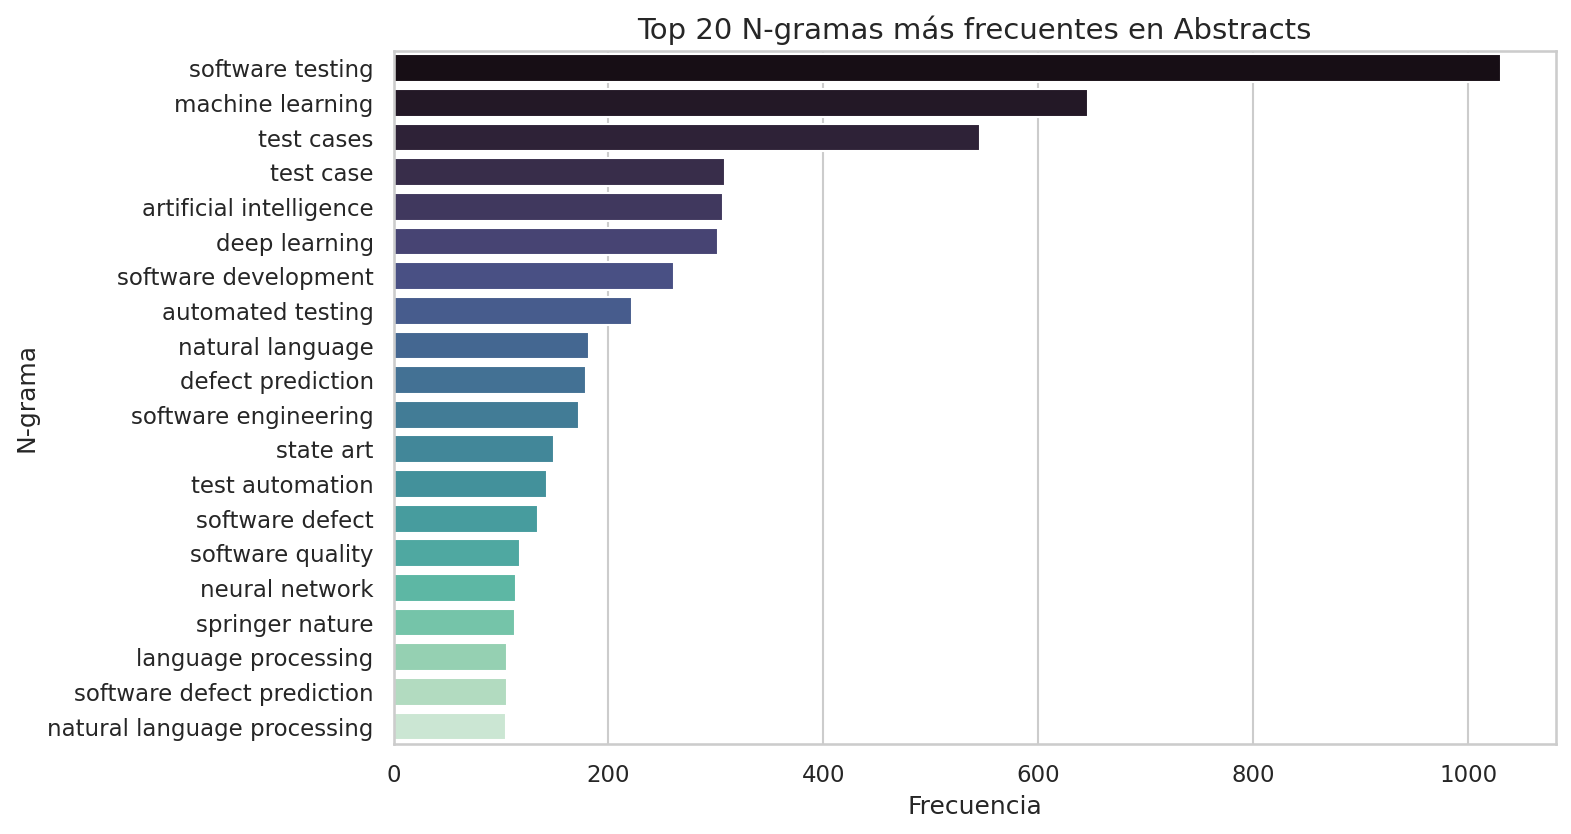

In [47]:
#N-gramas y términos en Abstracts
#Objetivo: encontrar frases comunes y términos recurrentes en los resúmenes.
# Unir todos los abstracts
abstracts = df['abstract'].fillna('').str.lower()

# N-gramas (2 y 3 palabras)
vectorizer = CountVectorizer(ngram_range=(2,3), stop_words='english').fit(abstracts)
X = vectorizer.transform(abstracts)
sum_words = X.sum(axis=0)

ngrams_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
ngrams_freq = sorted(ngrams_freq, key=lambda x: x[1], reverse=True)[:20]

# DataFrame
ngram_df = pd.DataFrame(ngrams_freq, columns=['ngram', 'freq'])

# Visualizar
plt.figure(figsize=(10,6))
sns.barplot(y='ngram', x='freq', data=ngram_df, palette='mako')
plt.title("Top 20 N-gramas más frecuentes en Abstracts", fontsize=14)
plt.xlabel("Frecuencia")
plt.ylabel("N-grama")
plt.show()

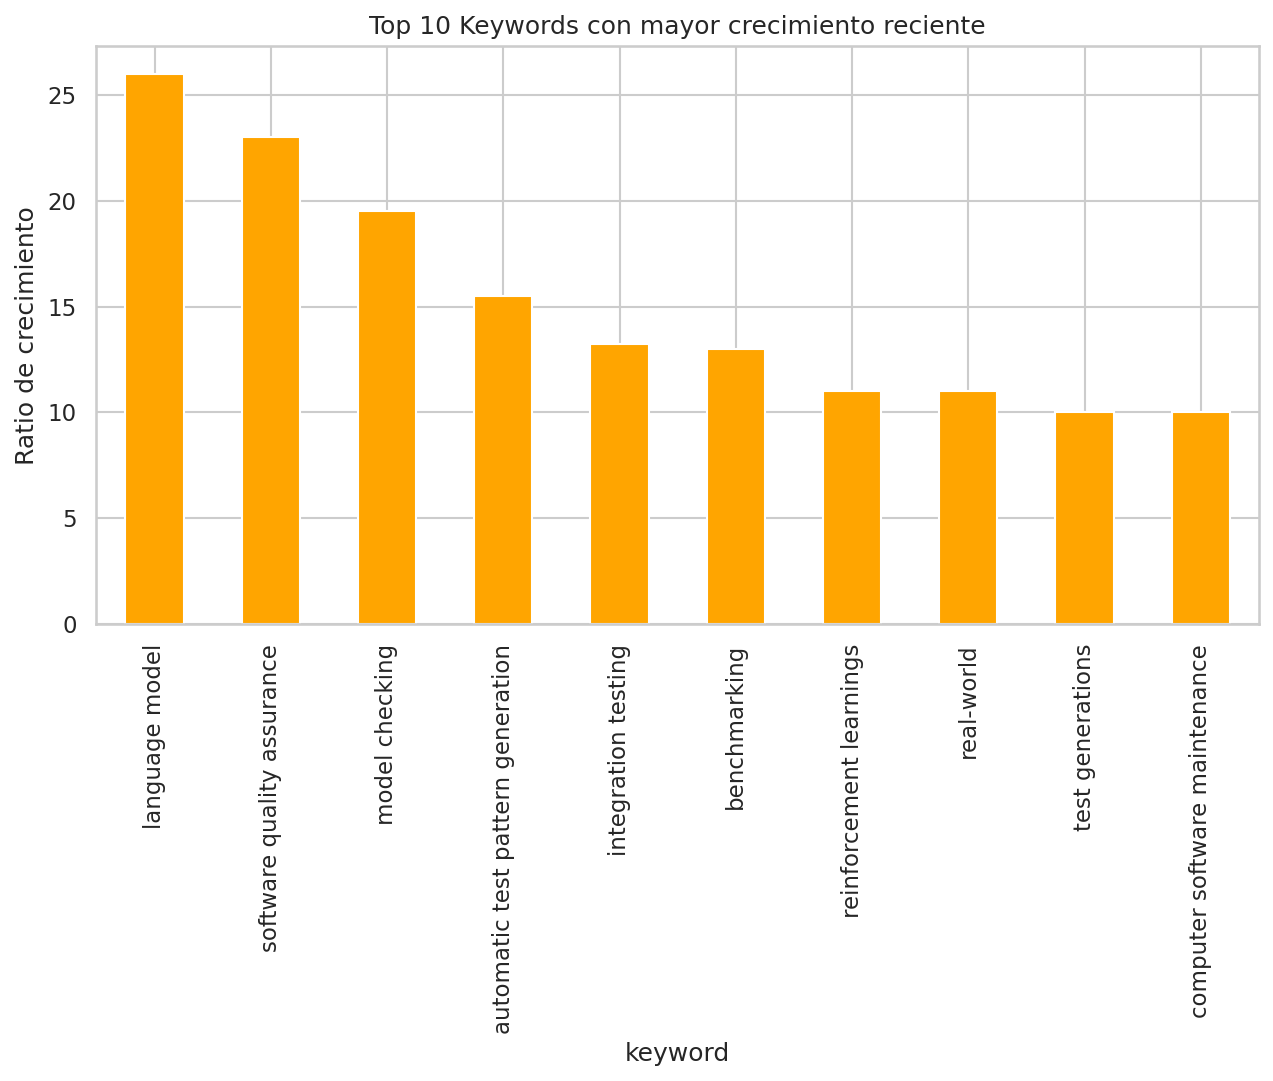

In [48]:
# Normalizamos año
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df.dropna(subset=['year'])

# Expandir keywords con año
rows = []
for _, row in df.iterrows():
    kws = (str(row['author_Keywords']) + ';' + str(row['index_keywords'])).split(';')
    for kw in kws:
        kw_clean = kw.strip().lower()
        if kw_clean:
            rows.append({'year': int(row['year']), 'keyword': kw_clean})

kw_year_df = pd.DataFrame(rows)

# Contar frecuencia por año
trend = kw_year_df.groupby(['keyword', 'year']).size().reset_index(name='count')

# Calcular crecimiento relativo (últimos 3 años vs resto)
latest_years = trend['year'].max() - 2
growth = (
    trend[trend['year'] >= latest_years]
    .groupby('keyword')['count'].sum()
    / trend[trend['year'] < latest_years]
    .groupby('keyword')['count'].sum()
)

growth = growth.sort_values(ascending=False).dropna().head(10)

# Visualizar crecimiento
growth.plot(kind='bar', figsize=(10,5), color='orange')
plt.title("Top 10 Keywords con mayor crecimiento reciente")
plt.ylabel("Ratio de crecimiento")
plt.show()

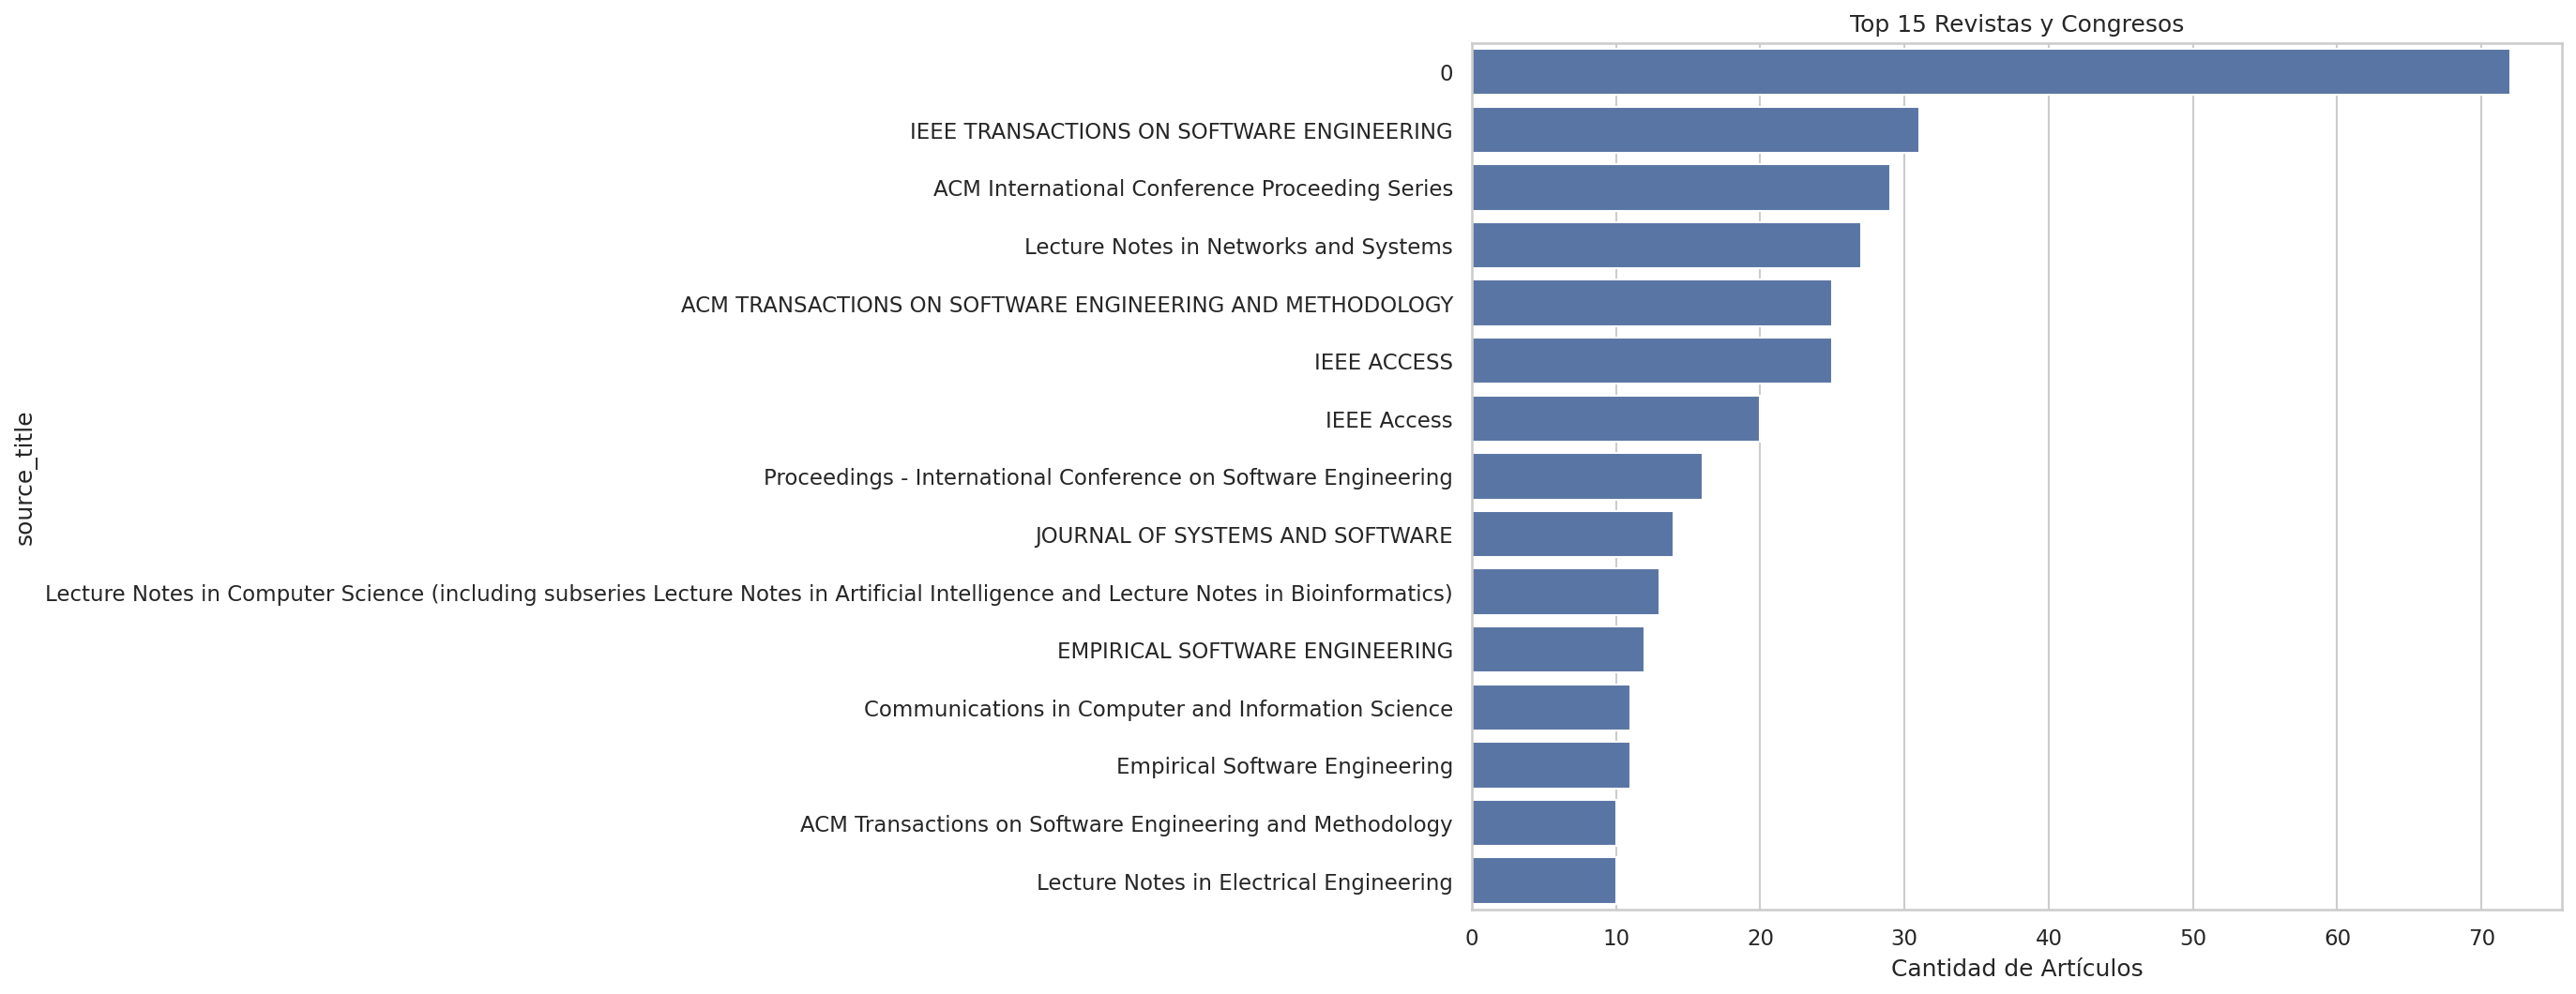

In [49]:
# Contar las 15 fuentes más comunes
top_sources = df['source_title'].value_counts().nlargest(15)

# Visualizar
plt.figure(figsize=(10, 8))
sns.barplot(x=top_sources.values, y=top_sources.index, orient='h')
plt.title('Top 15 Revistas y Congresos')
plt.xlabel('Cantidad de Artículos')
plt.show()

In [50]:
# Define el número de tópicos que quieres encontrar (esto es un hiperparámetro clave)
num_topics = 10 # Empezamos con 10 como una suposición educada

# Crea y entrena el modelo LDA
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

,n_components,10
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1
